In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score,GridSearchCV,cross_validate
import sklearn.metrics as metrics 
import matplotlib.cm as cm

# algorithms
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# data preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

# metrics
from sklearn.metrics import mean_squared_error, r2_score ,explained_variance_score


In [2]:
df = pd.read_excel("/Users/zaferavci/Documents/GitHub/Miuul-CaseStudy-1/Miuul-Case-Study/oppurtunity.xlsx", header=0) 

In [3]:
df.columns = [col.lower() for col in df.columns]

In [4]:
df.head()

opp. id           contactid          recordtype.name  \
0  0065G00000WOEXGQA5                 NaN         Expansion Income   
1  0065G00000WOEdEQAX  003f400000GtceBAAR  Silent Auction Purchase   
2  0065G00000WOEf0QAH  003f400001IklhmAAB                 Donation   
3  0065G00000WOEf1QAH  0035G00001aanl2QAA                 Donation   
4  0065G00000WOEf2QAH  0035G00001aanl3QAA                 Donation   

  account.name  amount platform__c  closedate donation_date__c   stagename  \
0        `3613   200.0         NaN 2020-10-22              NaT     Awarded   
1        `5059  2550.0         NaN 2020-06-30              NaT  Closed Won   
2        `0211    50.0    Facebook 2020-10-12              NaT  Closed Won   
3        `0219    80.0    Facebook 2020-10-16              NaT  Closed Won   
4        `0277    10.0    Facebook 2020-10-15              NaT  Closed Won   

  campaign.name  
0           NaN  
1      2020 EWC  
2           NaN  
3           NaN  
4           NaN

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   opp. id           16000 non-null  object        
 1   contactid         15069 non-null  object        
 2   recordtype.name   16000 non-null  object        
 3   account.name      15996 non-null  object        
 4   amount            15618 non-null  float64       
 5   platform__c       13849 non-null  object        
 6   closedate         16000 non-null  datetime64[ns]
 7   donation_date__c  7557 non-null   datetime64[ns]
 8   stagename         16000 non-null  object        
 9   campaign.name     12503 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 1.2+ MB


In [6]:
df.isnull().sum()

opp. id                0
contactid            931
recordtype.name        0
account.name           4
amount               382
platform__c         2151
closedate              0
donation_date__c    8443
stagename              0
campaign.name       3497
dtype: int64

In [7]:
# Eksik deƒüerlerin sayƒ±sƒ± ve y√ºzdesi
missing_df = df.isnull().sum().to_frame(name='Missing Count')
missing_df['Missing Ratio (%)'] = 100 * missing_df['Missing Count'] / len(df)
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)


In [8]:
missing_df

Missing Count  Missing Ratio (%)
donation_date__c           8443           52.76875
campaign.name              3497           21.85625
platform__c                2151           13.44375
contactid                   931            5.81875
amount                      382            2.38750
account.name                  4            0.02500

Missing Valuelarƒ±n Doldurulmasƒ±

In [9]:
# 1. 'donation_date__c' kolonunu tamamen sil
df.drop(columns=['donation_date__c'], inplace=True)

In [10]:
# 2. 'campaign.name' eksiklerini 'No campaign' ile doldur
df['campaign.name'] = df['campaign.name'].fillna('No campaign')

In [11]:
# 3. 'contactid' ve 'account.name' bo≈ü olan satƒ±rlarƒ± sil
df.dropna(subset=['contactid', 'account.name'], inplace=True)

In [12]:
# 4. 'amount' eksiklerini medyan ile doldur
df['amount'] = df['amount'].fillna(df['amount'].median())

Platform_c nin Campaign name ili≈ükisine g√∂re ko≈üullu mod ile doldurulmasƒ±

In [13]:
# Adƒ±m 1: Kƒ±rƒ±lma noktasƒ±nƒ± d√ºzeltiyoruz ‚Äì to_frame'e √∂zel isim veriyoruz
campaign_platform_ratio = (
    df[df['platform__c'].notnull()]
    .groupby(['campaign.name', 'platform__c'])
    .size()
    .reset_index(name='count')  # Bu artƒ±k tekrar etmeyen isim olacak
)

# Adƒ±m 2: Toplam kampanya sayƒ±sƒ±na g√∂re oranlarƒ± hesapla
total_counts = campaign_platform_ratio.groupby('campaign.name')['count'].transform('sum')
campaign_platform_ratio['ratio'] = campaign_platform_ratio['count'] / total_counts

In [14]:
campaign_platform_ratio.sort_values(by="count", ascending=False)

campaign.name  platform__c  count     ratio
387                               No campaign     Facebook   1260  0.514496
104                                  2023 EKC     PledgeIt    708  0.960651
359                    Every Kick Counts 2022     PledgeIt    631  0.954614
377                         Lydie's Loop 2022         Qgiv    543  0.985481
380                               No campaign  CTK Website    531  0.216823
..                                        ...          ...    ...       ...
270           2024 Indy Community Baby Shower        Check      1  1.000000
111   2023 EKC Golf Tournament Silent Auction  HBD Website      1  1.000000
278               2024 Lydie's Loop Donations  HBD Website      1  0.002681
61                    2022 EWC Table Captains  Give Lively      1  0.025641
275  2024 Iowa Hawkeye Fall Fundraising Event  Give Lively      1  0.026316

[407 rows x 4 columns]

In [15]:
# %90 √ºzeri e≈üle≈ümeleri al
strong_matches = campaign_platform_ratio[campaign_platform_ratio['ratio'] >= 0.9]

# S√∂zl√ºk olu≈ütur: {'Campaign.Name': 'Platform__c'}
campaign_to_platform = dict(zip(strong_matches['campaign.name'], strong_matches['platform__c']))

In [16]:
campaign_to_platform

{'10 for 10': 'Facebook',
 '2019 Summer Event': 'Check',
 '2020 Thank You': 'CTK Website',
 '2021 EWC Peer-to-Peer': 'Qgiv',
 '2021 EWC Reminder Postcard 4.26.21': 'Qgiv',
 '2021 EWC Table Captains': 'Qgiv',
 '2021 EWC Text to Give': 'Give Lively',
 '2022 EWC Board Pledges': 'Check',
 '2022 Giving Tuesday | Together We Count': 'Facebook',
 '2022 HBD Birthday Campaign': 'Give Lively',
 '2022 HBD Birthday Campgian': 'Give Lively',
 '2022 Honoring CJ': 'Give Lively',
 '2022 Kendra Scott Giveback Event': 'Check',
 '2023 CM In Person Ticket': 'FundEasy',
 '2023 CM Silent Auction': 'Square',
 '2023 EKC': 'PledgeIt',
 '2023 EKC Golf Tournament Foursome': 'FundEasy',
 '2023 EKC Golf Tournament In-Kind Donors': 'Check',
 '2023 EKC Golf Tournament Silent Auction': 'HBD Website',
 '2023 Gamechangers': 'PledgeIt',
 "2023 Lydie's Loop Donations": 'Qgiv',
 "2023 Lydie's Loop Registration": 'Qgiv',
 '2023 MCH Symposium Exhibitor': 'CTK Website',
 '2023 Walk of Remembrance': 'Qgiv',
 '2023 Walk of Rem

In [17]:
from tqdm import tqdm

for i in tqdm(df[df['platform__c'].isnull()].index):

    campaign = df.loc[i, 'campaign.name']
    recordtype = df.loc[i, 'recordtype.name']

    # 1. Kampanyaya g√∂re doldur
    if campaign in campaign_to_platform:
        df.at[i, 'platform__c'] = campaign_to_platform[campaign]

    # 2. Kampanya e≈üle≈ümedi, record type'a g√∂re mod
    elif pd.notnull(recordtype):
        platform_mode = df[df['recordtype.name'] == recordtype]['platform__c'].mode()
        if not platform_mode.empty:
            df.at[i, 'platform__c'] = platform_mode[0]

    # 3. Hi√ßbir ≈üey yoksa genel mod
    else:
        overall_mode = df['platform__c'].mode()
        if not overall_mode.empty:
            df.at[i, 'platform__c'] = overall_mode[0]

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1853/1853 [00:01<00:00, 984.48it/s]


In [18]:
df.isnull().sum()

opp. id            0
contactid          0
recordtype.name    0
account.name       0
amount             0
platform__c        0
closedate          0
stagename          0
campaign.name      0
dtype: int64

In [19]:
# ƒ∞lk olarak t√ºm object ve category kolonlarƒ±nƒ± al
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# ID gibi analizde kullanmak istemediƒüimiz kolonlarƒ± √ßƒ±kar
id_cols = ['opp. id', 'contactid', 'account.name']
cat_cols = [col for col in cat_cols if col not in id_cols]

# Sayƒ±sal kolonlar
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Tarih kolonlarƒ±
date_cols = df.select_dtypes(include=['datetime']).columns.tolist()

# Sonu√ßlarƒ± g√∂relim
print("Kategorik Deƒüi≈ükenler:", cat_cols)
print("Sayƒ±sal Deƒüi≈ükenler:", num_cols)
print("Tarih Deƒüi≈ükenleri:", date_cols)

Kategorik Deƒüi≈ükenler: ['recordtype.name', 'platform__c', 'stagename', 'campaign.name']
Sayƒ±sal Deƒüi≈ükenler: ['amount']
Tarih Deƒüi≈ükenleri: ['closedate']


Kategorik Deƒüi≈ükenler

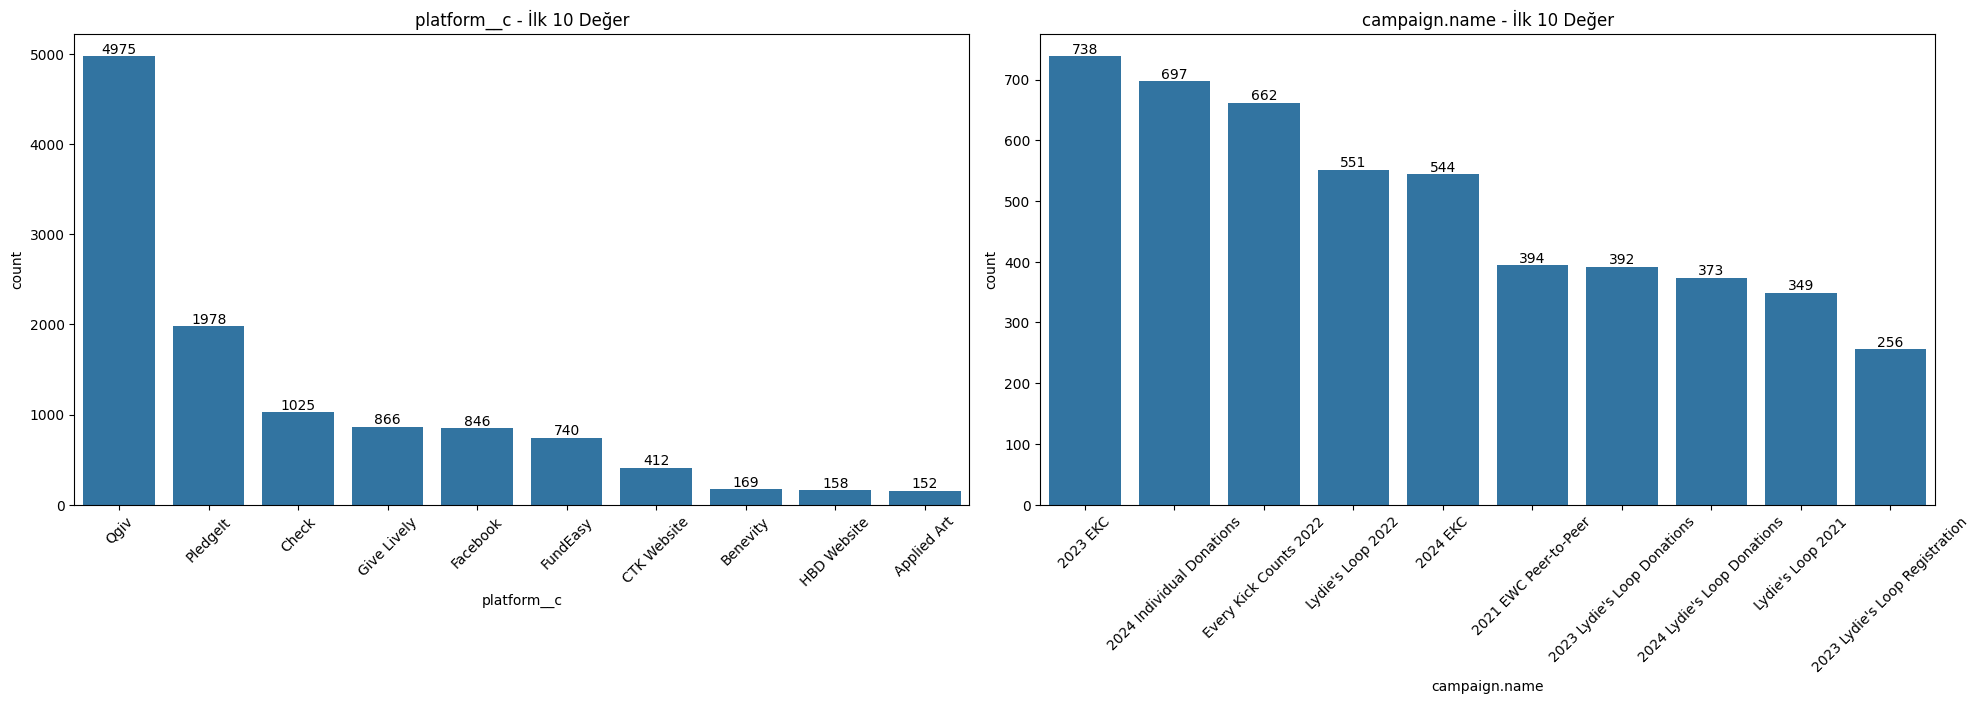

In [70]:
cat_cols = ['platform__c', 'campaign.name']

# No campaign'i filtrele
df_filtered = df[df['campaign.name'] != 'No campaign']

plt.figure(figsize=(20, 12))
for i, col in enumerate(cat_cols):
    plt.subplot(2, 2, i + 1)
    # En √ßok g√∂r√ºlen 10 kategori (No campaign hari√ß)
    order = df_filtered[col].value_counts().head(10).index  
    ax = sns.countplot(data=df_filtered, x=col, order=order)
    plt.title(f"{col} - ƒ∞lk 10 Deƒüer")
    plt.xticks(rotation=45)
    
    # S√ºtunlara deƒüer etiketlerini ekle
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)

plt.tight_layout()
plt.savefig("grafik_no_campaign_filtered.png", dpi=300)
plt.show()

Sayƒ±sal Deƒüi≈üken

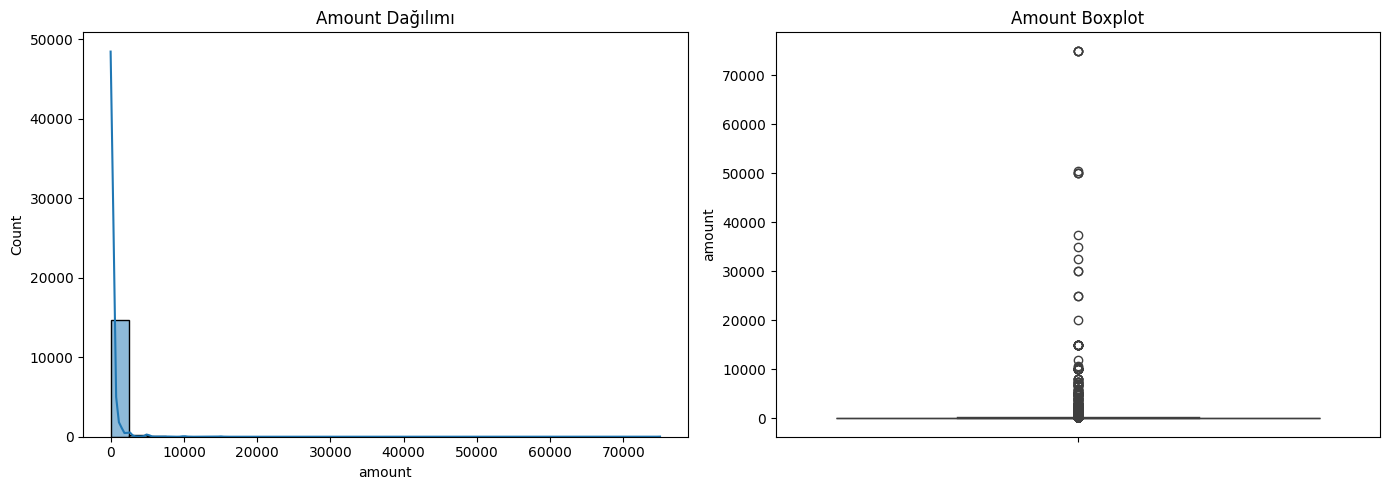

In [21]:
plt.figure(figsize=(14, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['amount'], kde=True, bins=30)
plt.title("Amount Daƒüƒ±lƒ±mƒ±")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=df, y='amount')
plt.title("Amount Boxplot")

plt.tight_layout()
plt.show()


In [22]:
def calculate_LB_UB (df,var):
    '''calculating upper bound and lower bound values to identify outliers'''
    Q3=np.percentile(df[var],75)
    Q1=np.percentile(df[var],25)
    IQR=1.5*(Q3-Q1)
    
    UB=Q3+IQR
    LB=Q1-IQR
    
    print(LB,UB)
    
    return LB,UB

In [23]:
#numerical_columns = df.select_dtypes('float64', 'int').columns

for i in num_cols:
    print("\n name of column:", i)
    LB, UB = calculate_LB_UB(df, i)
    print("min and max value", (df[i].min(), df[i].max()))
    print("range of outliers:", LB, UB)
    
    if df[i].max() > UB or df[i].min() < LB:
        print("----Investigate variable for outliers---")


 name of column: amount
-87.5 212.5
min and max value (np.float64(0.0), np.float64(75000.0))
range of outliers: -87.5 212.5
----Investigate variable for outliers---


Zaman Serisi Analizleri

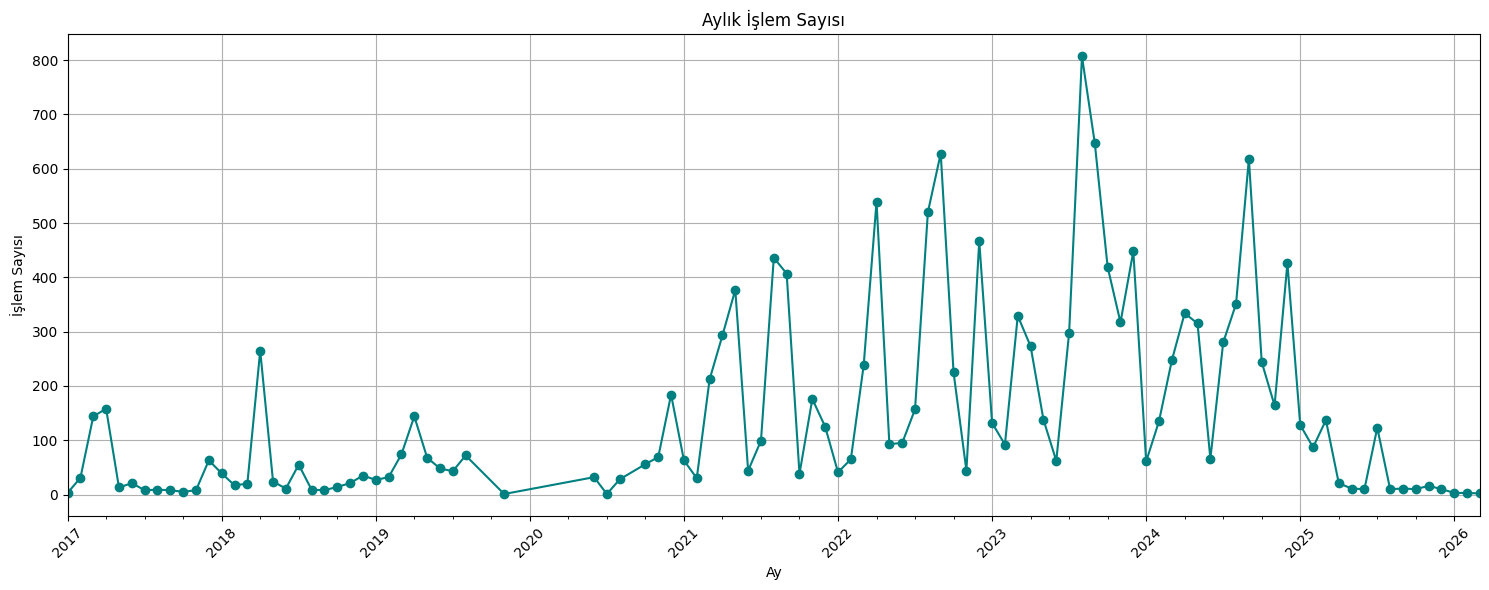

In [24]:
df['closedate'] = pd.to_datetime(df['closedate'], errors='coerce')

monthly_closed = df.groupby(df['closedate'].dt.to_period("M")).size()

plt.figure(figsize=(15, 6))
monthly_closed.plot(kind='line', marker='o', color='teal')
plt.title("Aylƒ±k ƒ∞≈ülem Sayƒ±sƒ±")
plt.xlabel("Ay")
plt.ylabel("ƒ∞≈ülem Sayƒ±sƒ±")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("aylƒ±ki≈ülem.png", dpi=300)
plt.show()
monthly_closed.to_excel("monthly.xlsx")


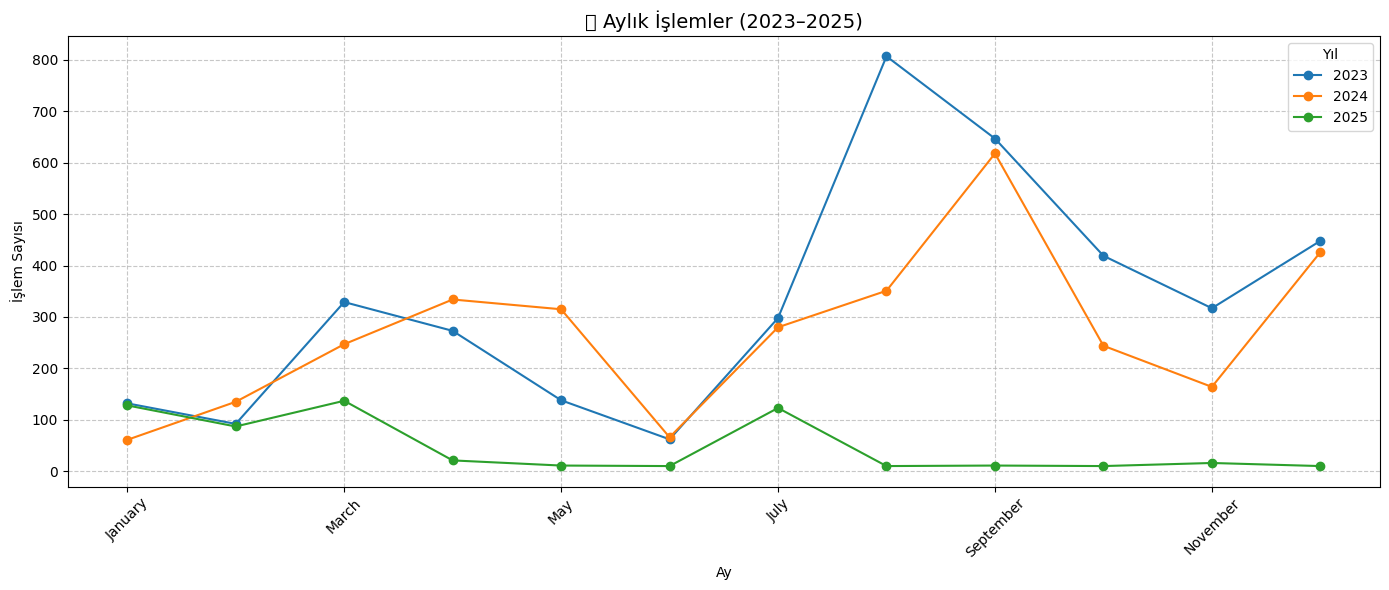

In [25]:
# closedate'i datetime formatƒ±na √ßevir
df['closedate'] = pd.to_datetime(df['closedate'], errors='coerce')

# Yƒ±l ve ay kolonlarƒ±nƒ± √ßƒ±kar
df['year'] = df['closedate'].dt.year
df['month'] = df['closedate'].dt.month_name()

# Sadece 2023-2025 yƒ±llarƒ±nƒ± filtrele
filtered = df[df['year'].isin([2023, 2024, 2025])]

# Ay sƒ±ralamasƒ± i√ßin sabit liste
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Pivot tablo: yƒ±l-ay bazlƒ± sayƒ±lar
monthly_by_year = (
    filtered.groupby(['year', 'month'])
    .size()
    .reset_index(name='count')
    .pivot(index='month', columns='year', values='count')
    .reindex(month_order)  # ay sƒ±rasƒ±na g√∂re d√ºzenle
)

# √áizgi grafiƒüi
monthly_by_year.plot(kind='line', marker='o', figsize=(14, 6))
plt.title("üìà Aylƒ±k ƒ∞≈ülemler (2023‚Äì2025)", fontsize=14)
plt.xlabel("Ay")
plt.ylabel("ƒ∞≈ülem Sayƒ±sƒ±")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Yƒ±l")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("yƒ±llƒ±ki≈ülem23-25.png", dpi=300)
plt.show()

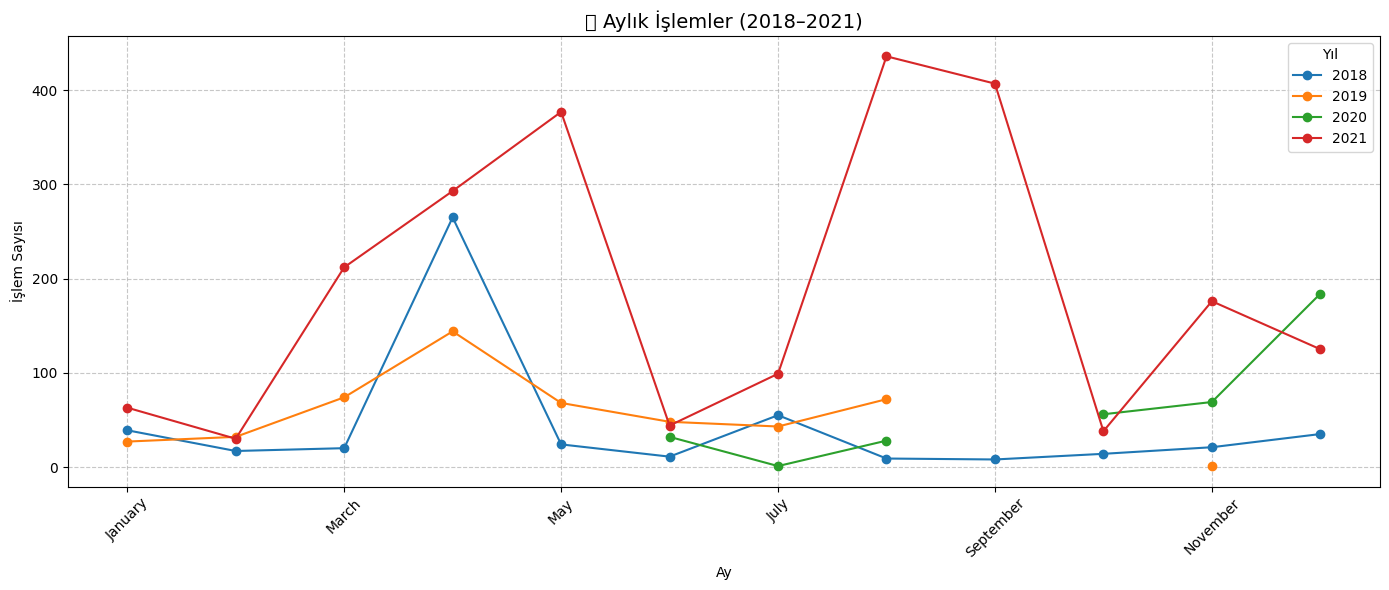

In [26]:

# Sadece 2023-2025 yƒ±llarƒ±nƒ± filtrele
filtered = df[df['year'].isin([2018, 2019, 2020, 2021])]

# Ay sƒ±ralamasƒ± i√ßin sabit liste
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Pivot tablo: yƒ±l-ay bazlƒ± sayƒ±lar
monthly_by_year = (
    filtered.groupby(['year', 'month'])
    .size()
    .reset_index(name='count')
    .pivot(index='month', columns='year', values='count')
    .reindex(month_order)  # ay sƒ±rasƒ±na g√∂re d√ºzenle
)

# √áizgi grafiƒüi
monthly_by_year.plot(kind='line', marker='o', figsize=(14, 6))
plt.title("üìà Aylƒ±k ƒ∞≈ülemler (2018‚Äì2021)", fontsize=14)
plt.xlabel("Ay")
plt.ylabel("ƒ∞≈ülem Sayƒ±sƒ±")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Yƒ±l")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("yƒ±llƒ±ki≈ülem18-21.png", dpi=300)
plt.show()

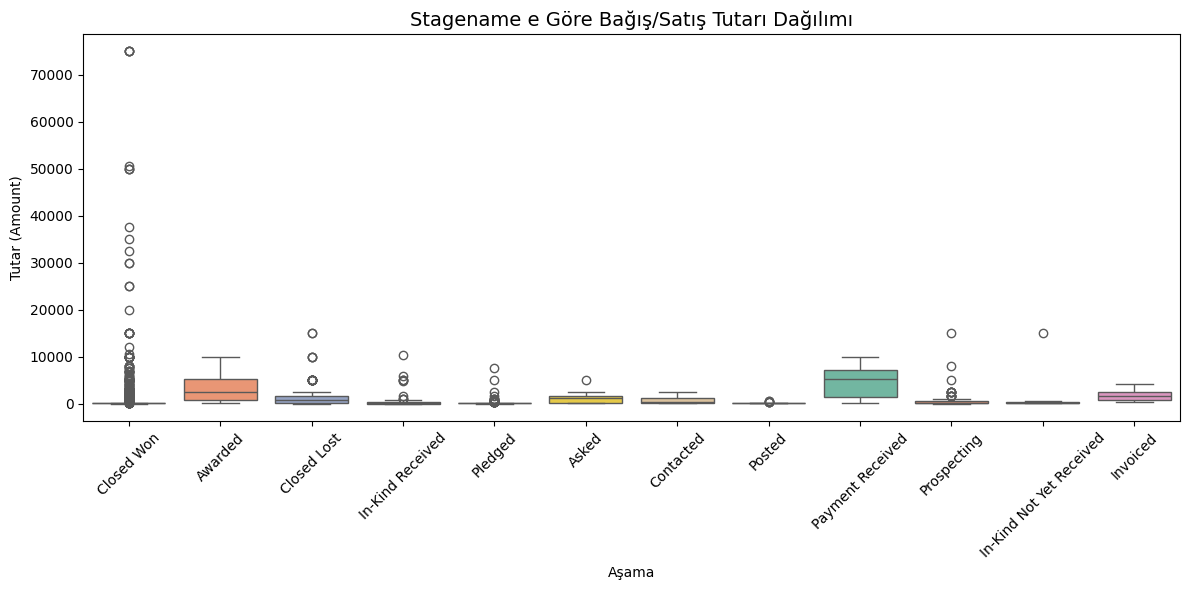

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='stagename', y='amount', palette='Set2')
plt.title("Stagename e G√∂re Baƒüƒ±≈ü/Satƒ±≈ü Tutarƒ± Daƒüƒ±lƒ±mƒ±", fontsize=14)
plt.xlabel("A≈üama")
plt.ylabel("Tutar (Amount)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [28]:
stage_amount_avg = df.groupby('stagename')['amount'].agg(['count', 'mean', 'median']).sort_values('count', ascending=False)
stage_amount_avg = stage_amount_avg.reset_index()
stage_amount_avg

stagename  count         mean  median
0                 Closed Won  14287   250.197866    50.0
1                    Pledged    234   176.906923    50.4
2                Closed Lost    223  1339.649462   750.0
3                Prospecting    131   636.236565   200.0
4           In-Kind Received     65   692.276923    50.0
5                      Asked     50  1078.000000  1125.0
6                     Posted     27   119.708889    75.0
7                   Invoiced     15  1708.333333  1500.0
8                    Awarded     11  3651.818182  2500.0
9           Payment Received     10  4860.000000  5250.0
10  In-Kind Not Yet Received      8  2000.000000    75.0
11                 Contacted      4   837.500000   400.0

=== Platform Bazlƒ± Tutar √ñzeti ===
                           count       total         mean   median
platform__c                                                       
Qgiv                        5481  1352396.15   246.742593    50.00
Facebook                    2106   124322.24    59.032403    25.00
PledgeIt                    1999   174259.66    87.173417    50.00
Check                       1200  1271682.00  1059.735000   250.00
CTK Website                  943   140167.30   148.639767    50.00
Give Lively                  936   102078.49   109.058216    50.00
FundEasy                     741   185869.65   250.836235   103.20
Benevity                     335    52679.55   157.252388    20.00
HBD Website                  184    31855.00   173.125000    50.00
Applied Art                  152    38270.00   251.776316    75.00
United Way                   146    35043.28   240.022466    57.32
Frontstream                  125    62231.38   497.851040   416.67
Direct Deposit           

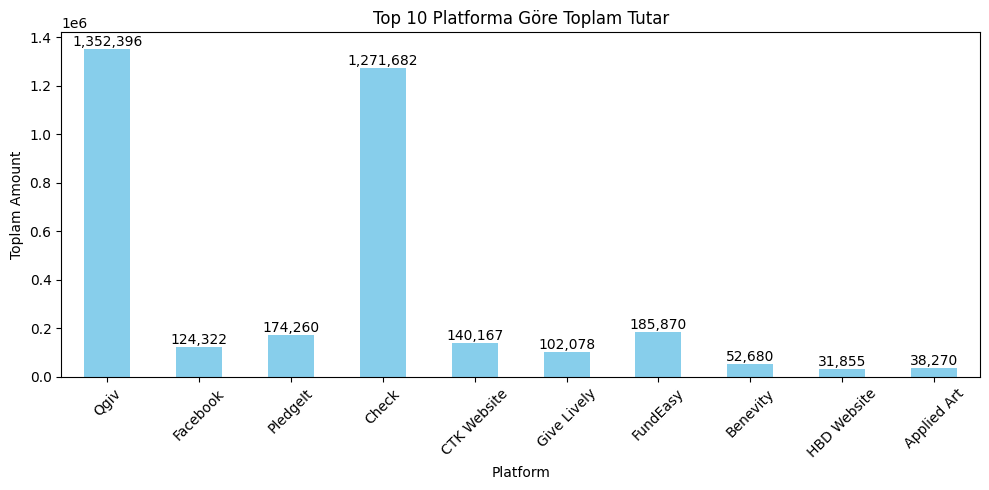

In [29]:
# 2.1 Platform Bazlƒ± Tutar Analizi
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
platform_amount = df.groupby('platform__c')['amount'].agg(
    count='count',
    total='sum',
    mean='mean',
    median='median'
).sort_values('count', ascending=False)

print("=== Platform Bazlƒ± Tutar √ñzeti ===")
print(platform_amount)

# Bar chart: Platform bazlƒ± toplam tutar
# ƒ∞lk 10 platformu al
top10_platforms = platform_amount.head(10)

# Grafik
plt.figure(figsize=(10,5))
ax = top10_platforms['total'].plot(kind='bar', color='skyblue')

plt.title("Top 10 Platforma G√∂re Toplam Tutar")
plt.xlabel("Platform")
plt.ylabel("Toplam Amount")
plt.xticks(rotation=45)

# S√ºtunlara deƒüer etiketlerini ekle
for i, value in enumerate(top10_platforms['total']):
    ax.text(i, value, f'{value:,.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("top10platformamunt.png", dpi=300)
plt.show()




=== En Yoƒüun 10 Kampanya Bazlƒ± Tutar √ñzeti ===
                             count     total        mean  median
campaign.name                                                   
2023 EKC                       738  72676.70   98.477913   50.00
2024 Individual Donations      697  84183.71  120.780072   26.01
Every Kick Counts 2022         662  64250.91   97.055755   50.00
Lydie's Loop 2022              551  36026.50   65.383848   40.00
2024 EKC                       544  58536.89  107.604577   50.00
2021 EWC Peer-to-Peer          394  59678.25  151.467640   63.00
2023 Lydie's Loop Donations    392  23936.15   61.061607   50.00
2024 Lydie's Loop Donations    373  22656.06   60.740107   50.00
Lydie's Loop 2021              349  24124.60   69.124928   40.00


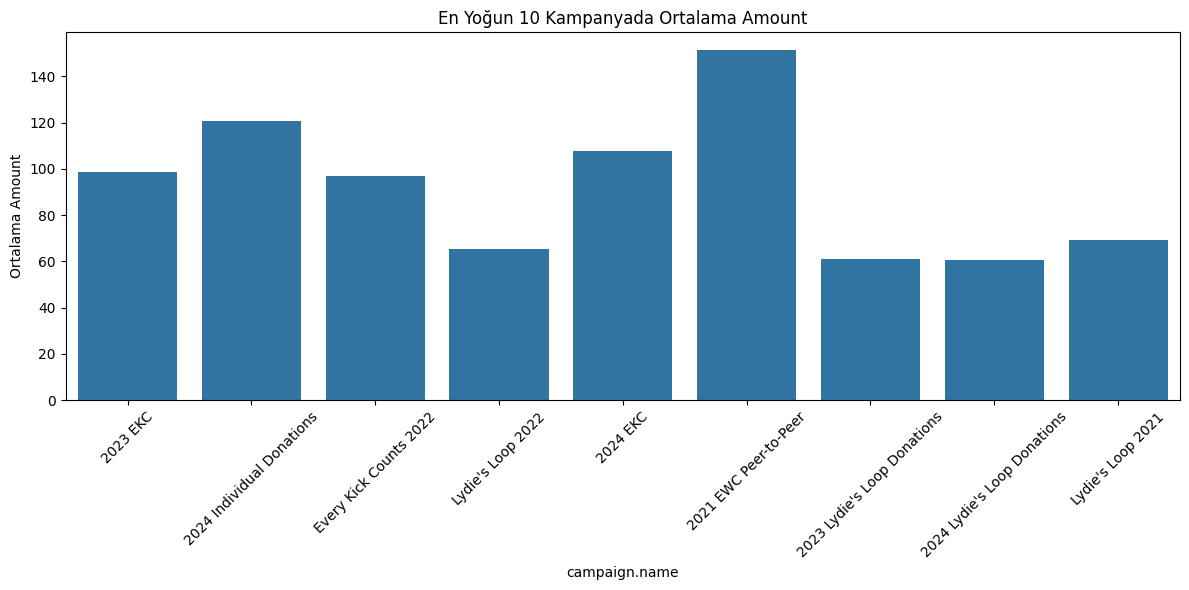

In [30]:
# 2.2 Kampanya Bazlƒ± Tutar Analizi (ƒ∞lk 10 Kampanya)
# ‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî‚Äî
top_campaigns = df['campaign.name'].value_counts().head(10).index
campaign_amount = df[df['campaign.name'].isin(top_campaigns)].groupby('campaign.name')['amount'].agg(
    count='count',
    total ='sum',
    mean='mean',
    median='median'
).sort_values('count', ascending=False)

campaign_amount = campaign_amount.drop("No campaign")

print("\n=== En Yoƒüun 10 Kampanya Bazlƒ± Tutar √ñzeti ===")
print(campaign_amount)

plt.figure(figsize=(12,6))
sns.barplot(
    data=campaign_amount.reset_index(),
    x='campaign.name', y='mean',
    order=campaign_amount.index
)
plt.title("En Yoƒüun 10 Kampanyada Ortalama Amount")
plt.xlabel("campaign.name")
plt.ylabel("Ortalama Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



PLATFORM BAZLI BA≈ûARI ORANI

=== Platform Ba≈üarƒ± Oranlarƒ± (%) ===
                           total   won    win_rate
platform__c                                       
YourCause                     47    47  100.000000
Grateful                       1     1  100.000000
Benevity                     335   335  100.000000
United Way                   146   146  100.000000
Truist                        63    63  100.000000
Community Foundation          45    45  100.000000
Cybergrants - CAF America     41    41  100.000000
Cybergrants - Nationwide      34    34  100.000000
Pledge.com                    16    16  100.000000
Frontstream                  125   125  100.000000
Applied Art                  152   152  100.000000
Facebook                    2106  2103   99.857550
Venmo                        111   110   99.099099
32Auctions                    57    56   98.245614
Instagram                     47    46   97.872340
CTK Website                  943   920   97.560976
Qgiv                        5481  5213   9

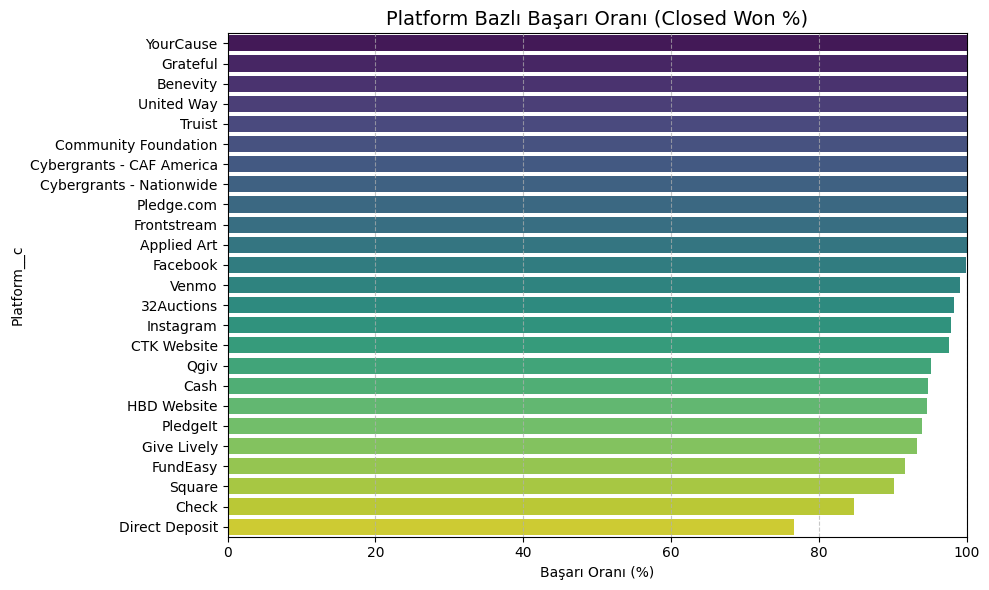

In [31]:
# 1. Kolon adlarƒ±nƒ± k√º√ß√ºlt ve stagename deƒüerlerini normalize et
df.columns = df.columns.str.strip().str.lower()
df['stagename'] = df['stagename'].str.strip().str.lower()

# 2. Platform bazlƒ± toplam fƒ±rsat sayƒ±sƒ±
platform_totals = df.groupby('platform__c').size().rename('total')

# 3. ‚Äúclosed won‚Äù olarak i≈üaretlenmi≈ü fƒ±rsat sayƒ±sƒ±
platform_won = (
    df[df['stagename'] == 'closed won']
    .groupby('platform__c')
    .size()
    .rename('won')
)

# 4. Win rate hesapla
platform_perf = pd.concat([platform_totals, platform_won], axis=1).fillna(0)
platform_perf['win_rate'] = platform_perf['won'] / platform_perf['total'] * 100

# 5. Sonu√ßlarƒ± tablo olarak yazdƒ±r
print("=== Platform Ba≈üarƒ± Oranlarƒ± (%) ===")
print(platform_perf.sort_values('win_rate', ascending=False)[['total','won','win_rate']])

# 6. Bar chart ile g√∂rselle≈ütir
plt.figure(figsize=(10,6))
order = platform_perf.sort_values('win_rate', ascending=False).index
sns.barplot(
    x=platform_perf.loc[order, 'win_rate'],
    y=order,
    palette='viridis'
)
plt.title("Platform Bazlƒ± Ba≈üarƒ± Oranƒ± (Closed Won %)", fontsize=14)
plt.xlabel("Ba≈üarƒ± Oranƒ± (%)")
plt.ylabel("Platform__c")
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

HAFTALIK VE AYLIK STAGE WON LOST TRENDLERƒ∞

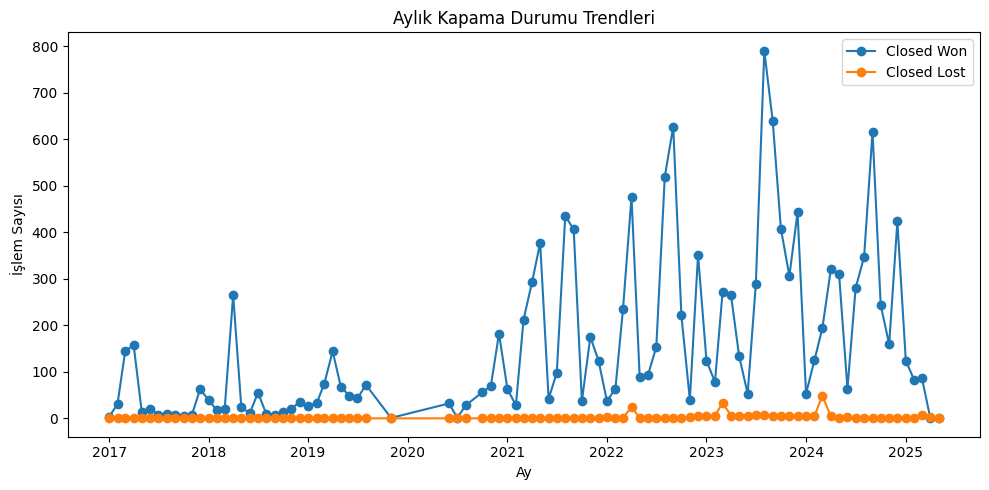

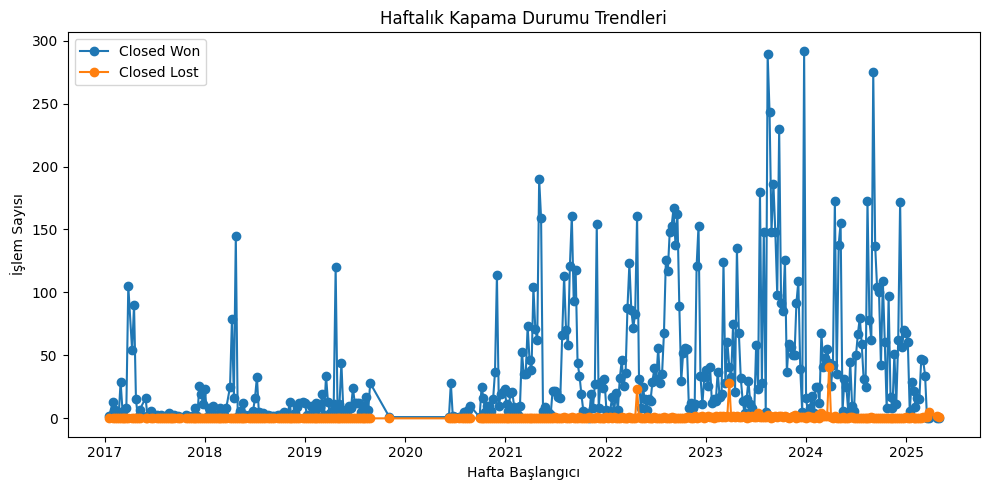

In [32]:
df['closedate'] = pd.to_datetime(df['closedate'], errors='coerce')
df['stagename'] = df['stagename'].str.strip().str.lower()

# 3. Sadece Closed Won ve Closed Lost kayƒ±tlarƒ±
df_trend = df[df['stagename'].isin(['closed won', 'closed lost'])].copy()

# 4. Aylƒ±k trend hesapla
monthly = (
    df_trend
    .groupby([df_trend['closedate'].dt.to_period('M'), 'stagename'])
    .size()
    .unstack(fill_value=0)
)
monthly.index = monthly.index.to_timestamp()

# 5. Haftalƒ±k trend hesapla (Pazartesi ba≈ülangƒ±√ßlƒ±)
weekly = (
    df_trend
    .groupby([df_trend['closedate'].dt.to_period('W-MON'), 'stagename'])
    .size()
    .unstack(fill_value=0)
)
weekly.index = weekly.index.to_timestamp()

# --- Grafik 1: Aylƒ±k Kapama Durumlarƒ± ---
plt.figure(figsize=(10, 5))
plt.plot(monthly.index, monthly['closed won'], marker='o', label='Closed Won')
plt.plot(monthly.index, monthly['closed lost'], marker='o', label='Closed Lost')
plt.title('Aylƒ±k Kapama Durumu Trendleri')
plt.xlabel('Ay')
plt.ylabel('ƒ∞≈ülem Sayƒ±sƒ±')
plt.legend()
plt.tight_layout()
plt.show()

# --- Grafik 2: Haftalƒ±k Kapama Durumlarƒ± ---
plt.figure(figsize=(10, 5))
plt.plot(weekly.index, weekly['closed won'], marker='o', label='Closed Won')
plt.plot(weekly.index, weekly['closed lost'], marker='o', label='Closed Lost')
plt.title('Haftalƒ±k Kapama Durumu Trendleri')
plt.xlabel('Hafta Ba≈ülangƒ±cƒ±')
plt.ylabel('ƒ∞≈ülem Sayƒ±sƒ±')
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
# Top 10 platformu satƒ±≈ü sayƒ±sƒ±na g√∂re belirle
top_platforms = (
    platform_campaign
    .groupby('platform__c')['transaction_count']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Bu 10 platform i√ßin veriyi filtrele
filtered = platform_campaign[platform_campaign['platform__c'].isin(top_platforms)]

# Her platformun en y√ºksek toplam tutara sahip 3 kampanyasƒ±
top_3_by_top_platforms = (
    filtered
    .sort_values(['platform__c', 'total_amount'], ascending=[True, False])
    .groupby('platform__c')
    .head(3)
)

# Platform adƒ±na g√∂re sƒ±ralama yapmak i√ßin sƒ±ralƒ± kategorilere d√∂n√º≈üt√ºr
top_3_by_top_platforms['platform__c'] = pd.Categorical(
    top_3_by_top_platforms['platform__c'],
    categories=top_platforms,
    ordered=True
)

# Grafik
plt.figure(figsize=(14, 8))
sns.barplot(
    data=top_3_by_top_platforms,
    x='platform__c',
    y='total_amount',
    hue='campaign.name',
    dodge=True
)

plt.title('Top 10 Platformun En Ba≈üarƒ±lƒ± 3 Kampanyasƒ± (Toplam Tutar Bazlƒ±)')
plt.xlabel('Platform')
plt.ylabel('Toplam Satƒ±≈ü Tutarƒ±')
plt.xticks(rotation=45)

# Bar etiketleri
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%.0f', label_type='edge', fontsize=8)

plt.tight_layout()
plt.savefig("top10_platform_top3_campaign.png", dpi=300)
plt.savefig("top10platform.png", dpi=300)
plt.show()


NameError: name 'platform_campaign' is not defined

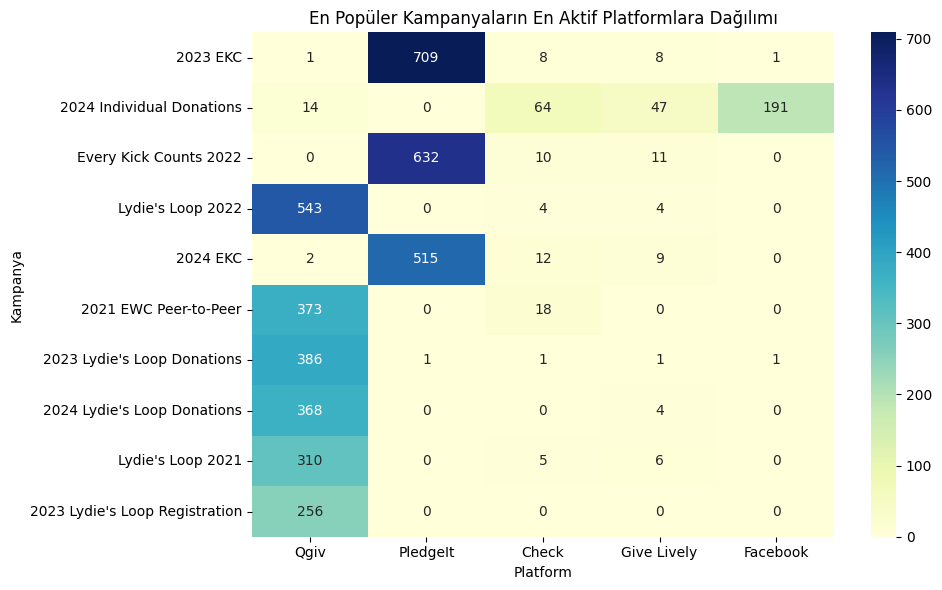

In [50]:
# Kampanyalarƒ±n platformlara g√∂re daƒüƒ±lƒ±mƒ±
campaign_platform_dist = pd.crosstab(df['campaign.name'], df['platform__c'])
campaign_platform_dist['total'] = campaign_platform_dist.sum(axis=1)
campaign_platform_dist = campaign_platform_dist.sort_values('total', ascending=False)

campaign_platform_dist.head()
campaign_platform_dist = campaign_platform_dist.drop('No campaign', axis=0)



# Sadece en √ßok kullanƒ±lan ilk 10 kampanya ve ilk 5 platform
top_campaigns = campaign_platform_dist.head(10).index
top_platforms = campaign_platform_dist.drop('total', axis=1).sum().sort_values(ascending=False).head(5).index

filtered = campaign_platform_dist.loc[top_campaigns, top_platforms]

plt.figure(figsize=(10, 6))
sns.heatmap(filtered, annot=True, fmt='g', cmap='YlGnBu')

plt.title('En Pop√ºler Kampanyalarƒ±n En Aktif Platformlara Daƒüƒ±lƒ±mƒ±')
plt.xlabel("Platform")
plt.ylabel("Kampanya")
plt.tight_layout()
plt.savefig("heatmap.png", dpi=300)
plt.show()


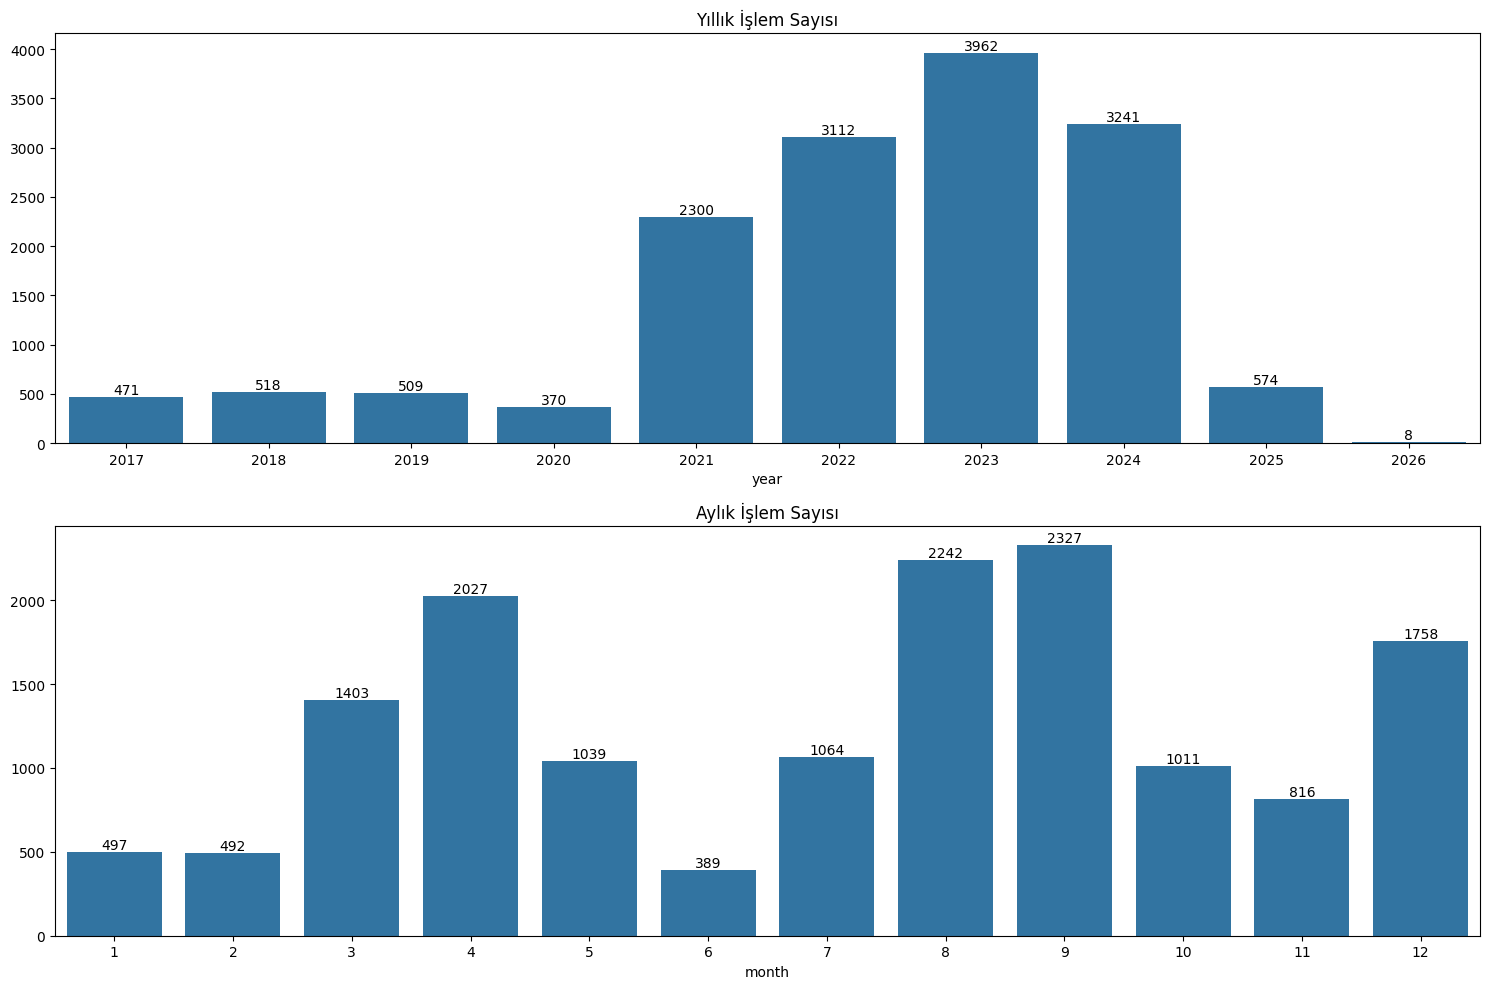

In [35]:
# Yƒ±llƒ±k ve aylƒ±k i≈ülem sayƒ±sƒ± analizi
df['year'] = df['closedate'].dt.year
df['month'] = df['closedate'].dt.month

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Yƒ±llƒ±k i≈ülem sayƒ±sƒ±
yearly_trans = df.groupby('year').size()
sns.barplot(x=yearly_trans.index, y=yearly_trans.values, ax=ax1)
ax1.set_title('Yƒ±llƒ±k ƒ∞≈ülem Sayƒ±sƒ±')
ax1.bar_label(ax1.containers[0])

# Aylƒ±k i≈ülem sayƒ±sƒ±
monthly_trans = df.groupby('month').size()
sns.barplot(x=monthly_trans.index, y=monthly_trans.values, ax=ax2)
ax2.set_title('Aylƒ±k ƒ∞≈ülem Sayƒ±sƒ±')
ax2.bar_label(ax2.containers[0])

plt.tight_layout()
plt.savefig("aylƒ±ki≈ülemsutun.png", dpi=300)
plt.show()

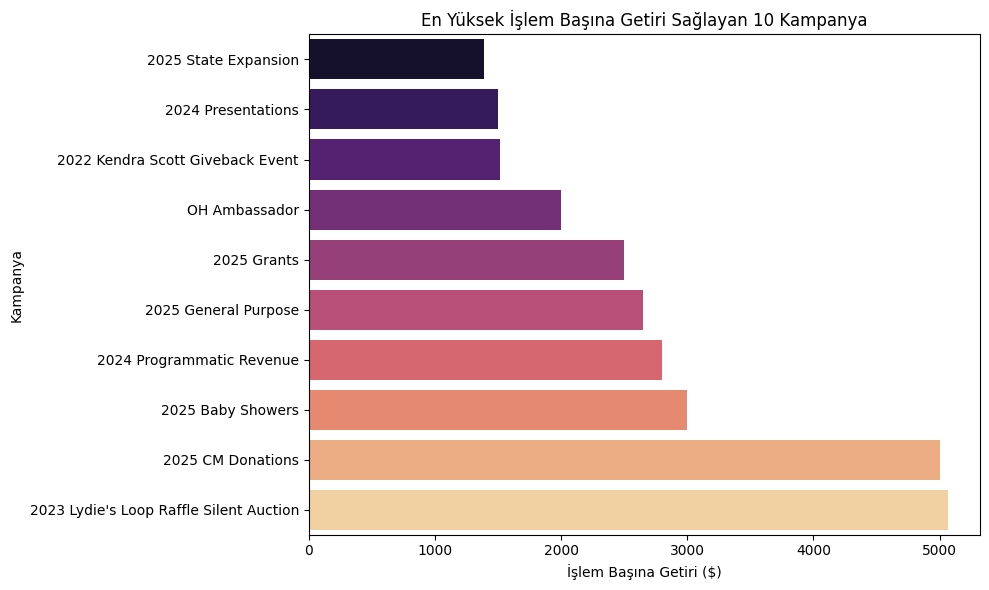


Y√ºksek Getiri / D√º≈ü√ºk Satƒ±≈ü Kampanyalarƒ±:
                                         transaction_count  total_revenue  \
campaign.name                                                               
2023 Lydie's Loop Raffle Silent Auction                  1        5067.00   
2025 CM Donations                                        1        5000.00   
2025 Baby Showers                                        1        3000.00   
2024 Programmatic Revenue                                5       70050.00   
2025 General Purpose                                     3       23850.00   
2025 Grants                                              1        2500.00   
OH Ambassador                                            1        2000.00   
2022 Kendra Scott Giveback Event                         1        1516.45   
2024 Presentations                                       1        1500.00   
2025 State Expansion                                     2        5550.00   

                         

In [36]:
# Getiri-satƒ±≈ü analizi
df['revenue_per_transaction'] = df['amount'] / df.groupby('campaign.name')['amount'].transform('count')

# Az satƒ±≈ü y√ºksek getiri analizi
high_revenue_low_sales = df.groupby('campaign.name').agg({
    'amount': ['count', 'sum'],
    'revenue_per_transaction': 'mean'
}).round(2)

high_revenue_low_sales.columns = ['transaction_count', 'total_revenue', 'revenue_per_transaction']
high_revenue_low_sales = high_revenue_low_sales.sort_values('revenue_per_transaction', ascending=False)

top10 = high_revenue_low_sales.head(10).sort_values('revenue_per_transaction')

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10,
    x='revenue_per_transaction',
    y=top10.index,
    palette='magma'
)

plt.title('En Y√ºksek ƒ∞≈ülem Ba≈üƒ±na Getiri Saƒülayan 10 Kampanya')
plt.xlabel('ƒ∞≈ülem Ba≈üƒ±na Getiri ($)')
plt.ylabel('Kampanya')
plt.tight_layout()
plt.savefig("eny√ºksekgetiri.png", dpi=300)
plt.show()



print("\nY√ºksek Getiri / D√º≈ü√ºk Satƒ±≈ü Kampanyalarƒ±:")
print(high_revenue_low_sales.head(10))

In [37]:
# 10 for 10 kampanya analizi
ten_for_ten = df[df['campaign.name'].str.contains('10 for 10', na=False)]
ten_for_ten_platform = ten_for_ten.groupby('platform__c').agg({
    'amount': ['count', 'sum', 'mean'],
    'stagename': lambda x: (x == 'closed won').mean() * 100
}).round(2)

print("\n10 for 10 Kampanya Platform Analizi:")
print(ten_for_ten_platform)


10 for 10 Kampanya Platform Analizi:
            amount                stagename
             count     sum   mean  <lambda>
platform__c                                
Facebook        64  2746.0  42.91     100.0


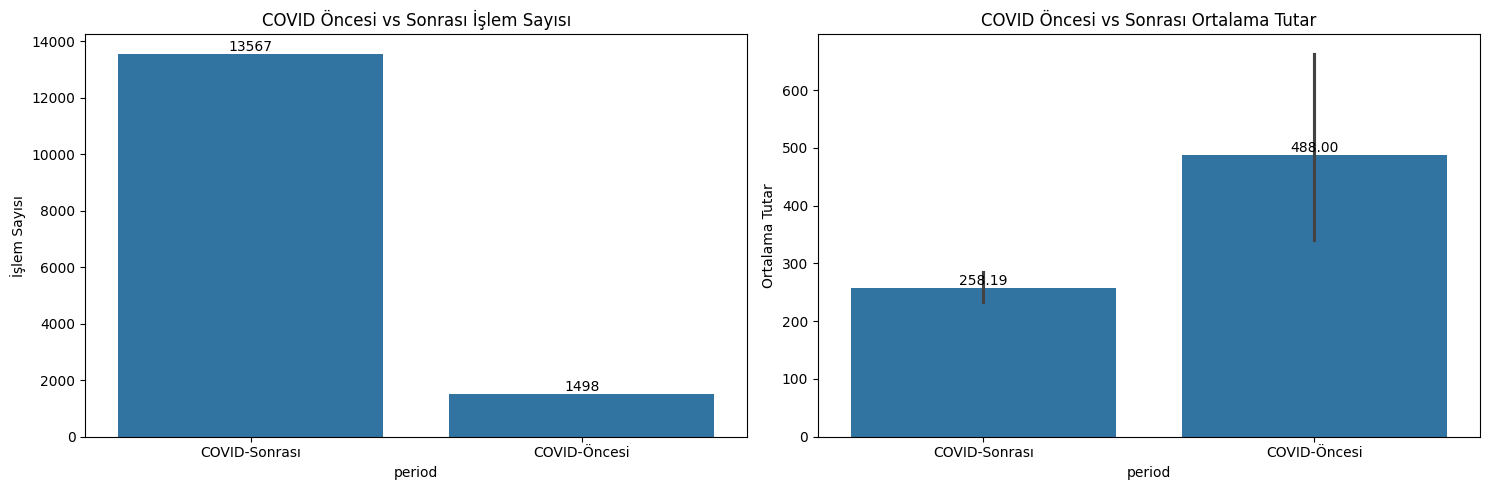

In [38]:
# 1. COVID-19 √ñncesi ve Sonrasƒ± Analiz (2020 Mart ayƒ± baz alƒ±narak)
df['closedate'] = pd.to_datetime(df['closedate'], errors='coerce')  # Tarih formatƒ± g√ºvenliƒüi
df['period'] = df['closedate'].apply(lambda x: 'COVID-√ñncesi' if x < pd.Timestamp('2020-03-01') else 'COVID-Sonrasƒ±')

# COVID √∂ncesi ve sonrasƒ± performans kar≈üƒ±la≈ütƒ±rmasƒ± (stagename olmadan)
covid_analysis = df.groupby('period').agg({
    'amount': ['count', 'sum', 'mean']
}).round(2)

covid_analysis.columns = ['transaction_count', 'total_amount', 'avg_amount']


# G√∂rselle≈ütirme
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ‚úÖ ƒ∞≈ülem Sayƒ±sƒ± Kar≈üƒ±la≈ütƒ±rmasƒ± (countplot ile)
sns.countplot(data=df, x='period', ax=ax1)
ax1.set_title('COVID √ñncesi vs Sonrasƒ± ƒ∞≈ülem Sayƒ±sƒ±')
ax1.set_ylabel('ƒ∞≈ülem Sayƒ±sƒ±')
ax1.bar_label(ax1.containers[0])

# Ortalama Tutar Kar≈üƒ±la≈ütƒ±rmasƒ±
sns.barplot(data=df, x='period', y='amount', estimator=np.mean, ax=ax2)
ax2.set_title('COVID √ñncesi vs Sonrasƒ± Ortalama Tutar')
ax2.set_ylabel('Ortalama Tutar')
ax2.bar_label(ax2.containers[0], fmt='%.2f')

plt.tight_layout()
plt.savefig("covid.png", dpi=300)
plt.show()
# toplam tutar da ekle

In [39]:
df.groupby("period").agg({"amount":"sum"})

amount
period                   
COVID-Sonrasƒ±  3502909.23
COVID-√ñncesi    731027.86

2020 Sonrasƒ± Ay Bazƒ±nda Toplam Benzersiz Kampanya Sayƒ±sƒ±:
        month  campaign_count
0     January              35
1    February              41
2       March              53
3       April              51
4         May              38
5        June              23
6        July              47
7      August              50
8   September              44
9     October              43
10   November              38
11   December              36


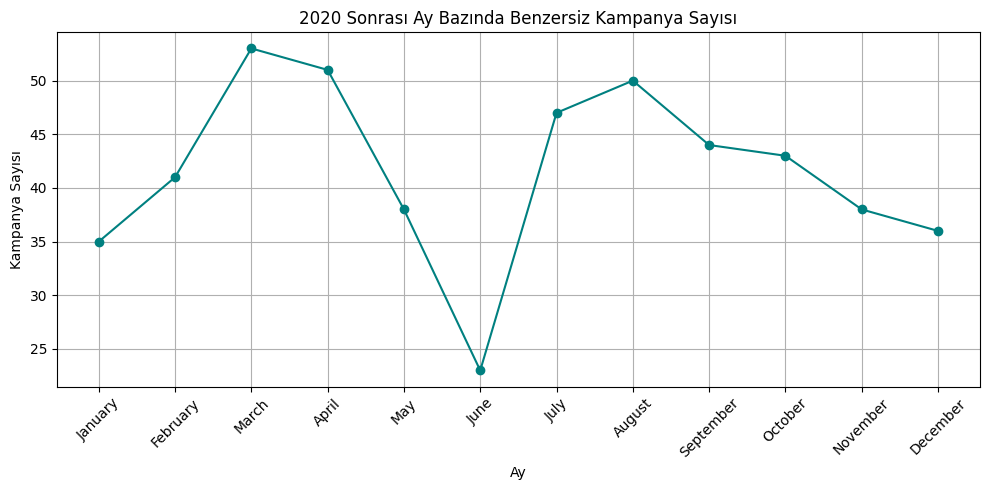

In [43]:
# 1. 'closedate' s√ºtununu datetime formatƒ±na √ßeviriyoruz
df['closedate'] = pd.to_datetime(df['closedate'], errors='coerce')

# 2. 2020 ve sonrasƒ± i√ßin filtreleme yapƒ±yoruz
df_post2020 = df[df['closedate'].dt.year >= 2020]

# 3. 'No campaign' olan kayƒ±tlarƒ± hari√ß tutuyoruz
df_campaign = df_post2020[df_post2020['campaign.name'] != 'No campaign']

# 4. Ay ismini olu≈üturuyoruz (√∂rn. January, February, ...)
df_campaign['month'] = df_campaign['closedate'].dt.month_name()

# 5. Her ay i√ßin benzersiz kampanya sayƒ±sƒ±nƒ± hesaplƒ±yoruz
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

monthly_campaign_count = (
    df_campaign.groupby('month')['campaign.name']
    .nunique()
    .reindex(month_order)
    .reset_index(name='campaign_count')
)

print("2020 Sonrasƒ± Ay Bazƒ±nda Toplam Benzersiz Kampanya Sayƒ±sƒ±:")
print(monthly_campaign_count)

# 6. Sonu√ßlarƒ± g√∂rselle≈ütiriyoruz
plt.figure(figsize=(10, 5))
plt.plot(monthly_campaign_count['month'],
         monthly_campaign_count['campaign_count'],
         marker='o', linestyle='-', color='teal')
plt.title("2020 Sonrasƒ± Ay Bazƒ±nda Benzersiz Kampanya Sayƒ±sƒ±")
plt.xlabel("Ay")
plt.ylabel("Kampanya Sayƒ±sƒ±")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("monthly_campaign_count_by_month.png", dpi=300)
plt.show()

Her Platformda Benzersiz Kampanya Sayƒ±sƒ±:
                  platform__c  unique_campaigns
0                  32Auctions                 2
1                 Applied Art                 3
2                    Benevity                 5
3                 CTK Website                36
4                        Cash                 9
5                       Check                98
6        Community Foundation                24
7   Cybergrants - CAF America                 4
8    Cybergrants - Nationwide                 1
9              Direct Deposit                25
10                   Facebook                15
11                Frontstream                 2
12                   FundEasy                33
13                Give Lively                55
14                   Grateful                 1
15                HBD Website                14
16                  Instagram                 5
17                 Pledge.com                 1
18                   PledgeIt               

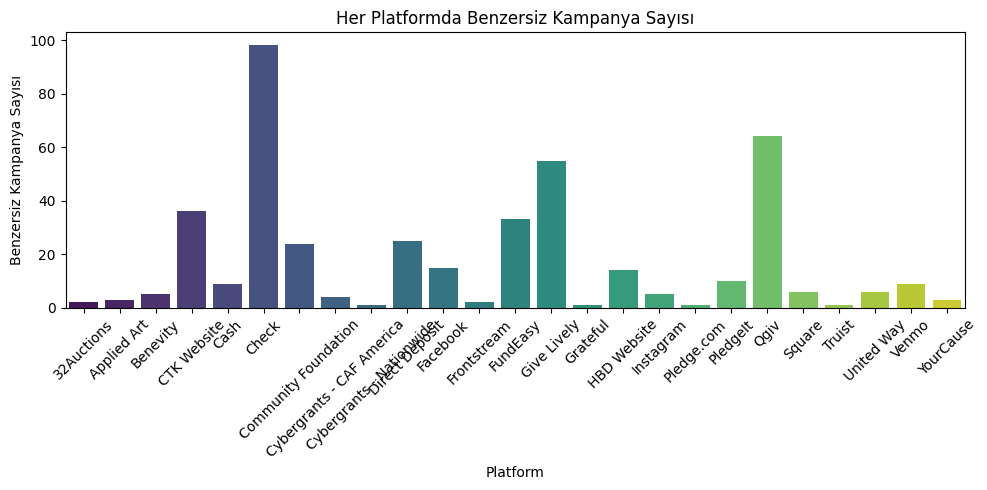

In [52]:
# 1. 'No campaign' kayƒ±tlarƒ±nƒ± hari√ß tutarak kampanya verilerini filtreleyin
df_campaign = df[df['campaign.name'] != 'No campaign']

# 2. Her platform i√ßin benzersiz kampanya sayƒ±sƒ±nƒ± hesaplayƒ±n
platform_campaign_count = (
    df_campaign.groupby('platform__c')['campaign.name']
    .nunique()
    .reset_index(name='unique_campaigns')
)

print("Her Platformda Benzersiz Kampanya Sayƒ±sƒ±:")
print(platform_campaign_count)

# 3. Sonu√ßlarƒ± g√∂rselle≈ütirin
plt.figure(figsize=(10, 5))
sns.barplot(data=platform_campaign_count,
            x='platform__c',
            y='unique_campaigns',
            palette='viridis')
plt.title("Her Platformda Benzersiz Kampanya Sayƒ±sƒ±")
plt.xlabel("Platform")
plt.ylabel("Benzersiz Kampanya Sayƒ±sƒ±")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("platform_unique_campaigns.png", dpi=300)
plt.show()

Her Platformda Benzersiz Kullanƒ±cƒ± Sayƒ±sƒ±:
                  platform__c  unique_users
19                       Qgiv          3456
18                   PledgeIt          1592
10                   Facebook          1480
5                       Check           651
3                 CTK Website           614
13                Give Lively           603
12                   FundEasy           549
15                HBD Website           154
1                 Applied Art           148
23                      Venmo           107
20                     Square            83
9              Direct Deposit            73
0                  32Auctions            55
2                    Benevity            51
16                  Instagram            46
22                 United Way            25
6        Community Foundation            24
17                 Pledge.com            13
4                        Cash            11
7   Cybergrants - CAF America             9
11                Frontstream

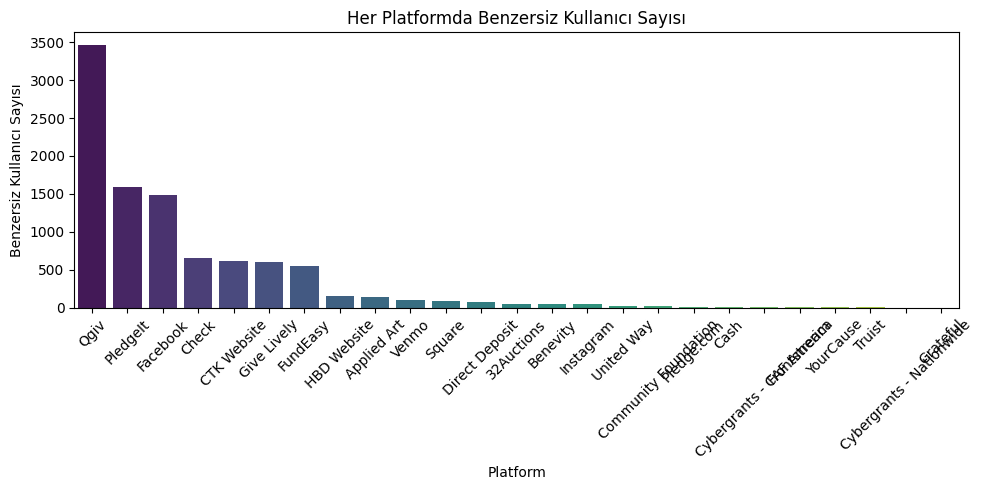

In [48]:
# Her platform i√ßin benzersiz kullanƒ±cƒ± sayƒ±sƒ±nƒ± hesaplayƒ±n (√∂rneƒüin: 'contactid' kullanƒ±lƒ±yor)
unique_user_count = (
    df.groupby('platform__c')['contactid']
      .nunique()
      .reset_index(name='unique_users')
)
unique_user_count = unique_user_count.sort_values(by="unique_users", ascending=False)
print("Her Platformda Benzersiz Kullanƒ±cƒ± Sayƒ±sƒ±:")
print(unique_user_count)

# Sonu√ßlarƒ± g√∂rselle≈ütirin
plt.figure(figsize=(10, 5))
sns.barplot(data=unique_user_count,
            x='platform__c',
            y='unique_users',
            palette='viridis')
plt.title("Her Platformda Benzersiz Kullanƒ±cƒ± Sayƒ±sƒ±")
plt.xlabel("Platform")
plt.ylabel("Benzersiz Kullanƒ±cƒ± Sayƒ±sƒ±")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("platform_unique_users.png", dpi=300)
plt.show()

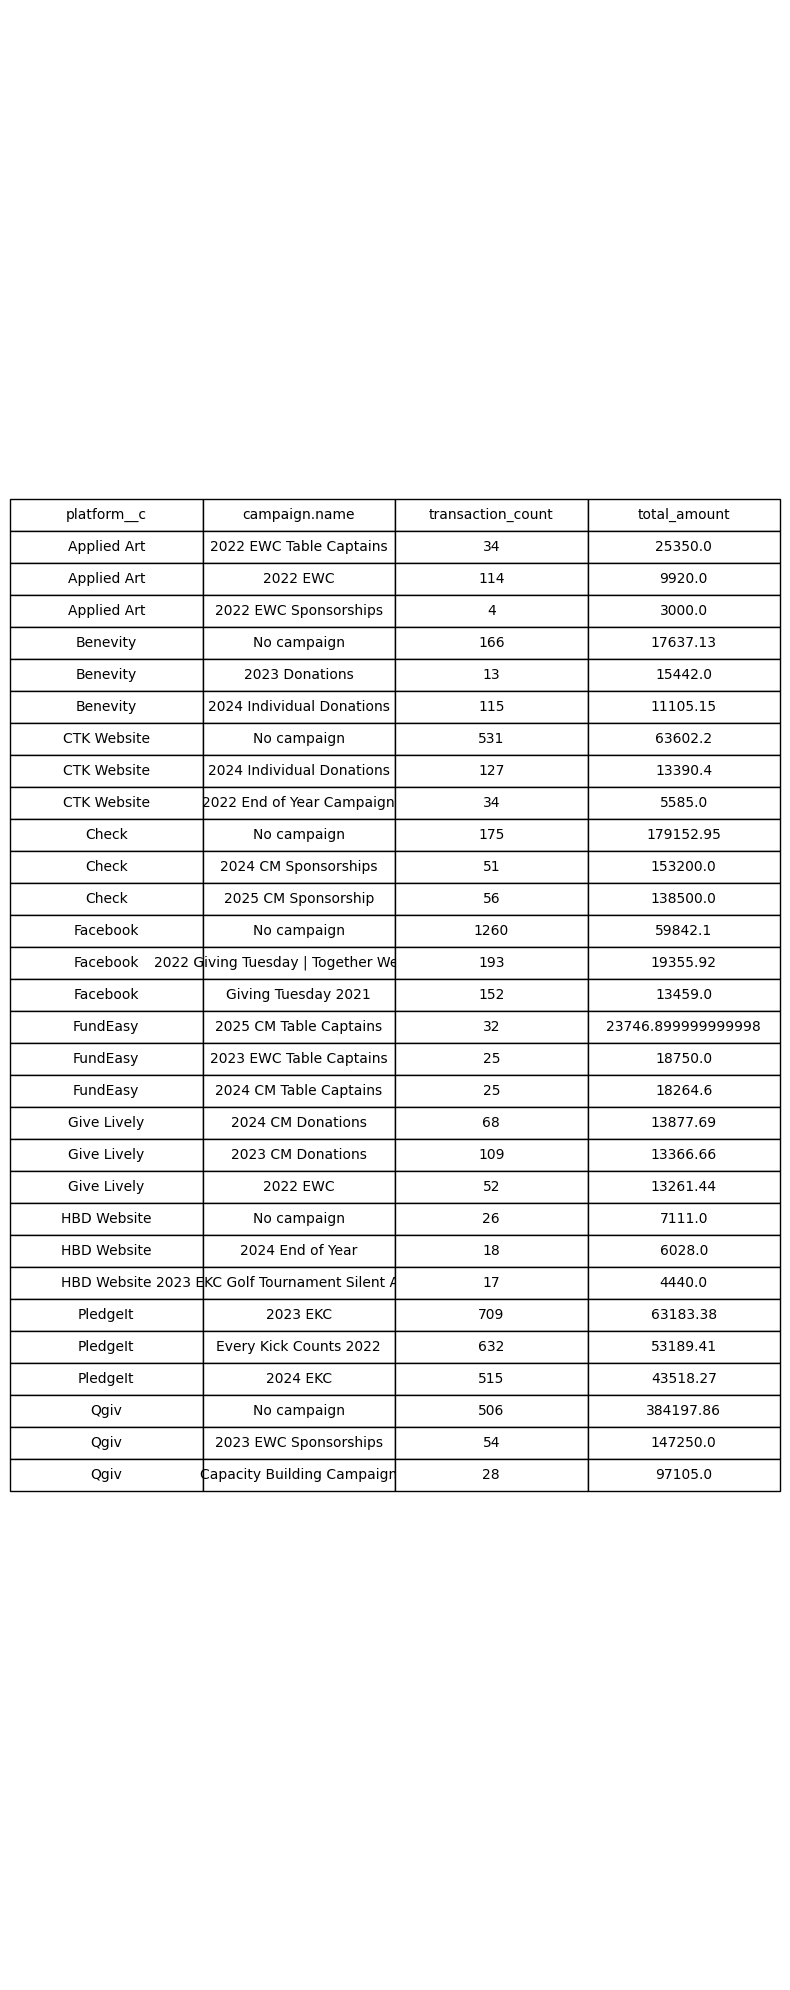

In [58]:
import matplotlib.pyplot as plt

# DataFrame'in boyutuna g√∂re uyarlanabilir ≈üekilde fig√ºr boyutunu ayarlƒ±yoruz
n_rows = len(top_3_by_top_platforms)
fig, ax = plt.subplots(figsize=(top_3_by_top_platforms.shape[1]*2, n_rows*0.6 + 2))

# Eksenleri kapatƒ±yoruz
ax.axis('tight')
ax.axis('off')

# Tabloyu olu≈üturuyoruz
table = ax.table(cellText=top_3_by_top_platforms.values,
                 colLabels=top_3_by_top_platforms.columns,
                 cellLoc='center',
                 loc='center')

# Yazƒ± boyutunu ayarlama (isteƒüe baƒülƒ±)
table.auto_set_font_size(False)
table.set_fontsize(10)

# S√ºtun geni≈üliklerini ayarlamak i√ßin
table.scale(1, 1.5)

plt.tight_layout()
plt.savefig("top_3_platforms_table.png", dpi=300)
plt.show()

Top 10 Kampanya - ƒ∞≈ülem Adedi:
                      campaign.name  transaction_count
41                         2023 EKC                738
93        2024 Individual Donations                697
142          Every Kick Counts 2022                662
149               Lydie's Loop 2022                551
83                         2024 EKC                544
14            2021 EWC Peer-to-Peer                394
54      2023 Lydie's Loop Donations                392
100     2024 Lydie's Loop Donations                373
148               Lydie's Loop 2021                349
56   2023 Lydie's Loop Registration                256


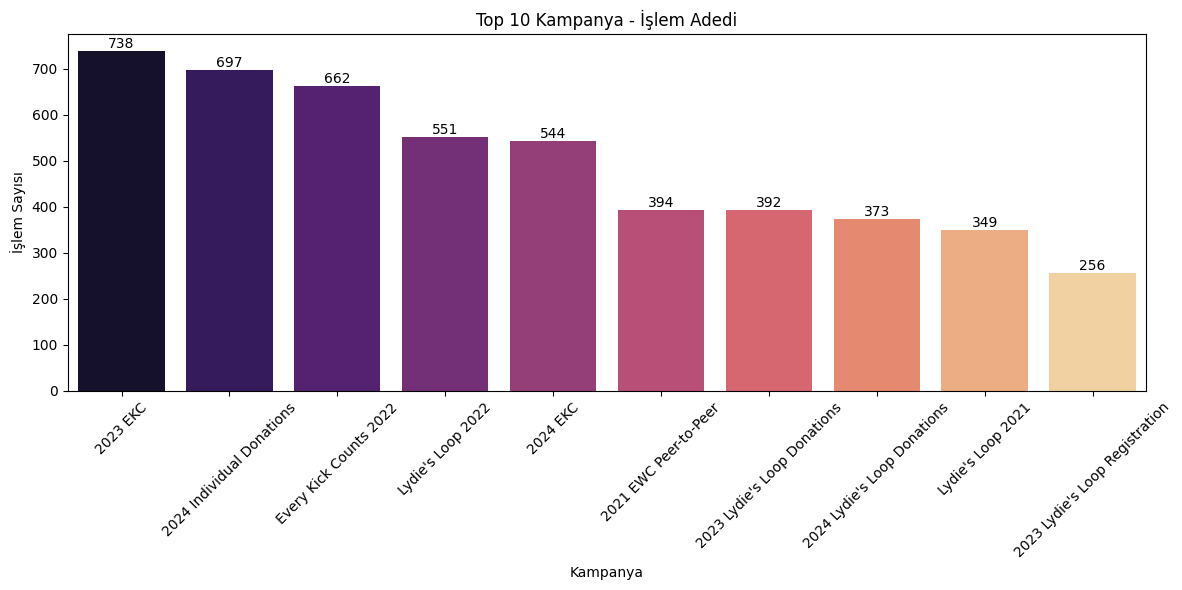

In [64]:
# "No campaign" kayƒ±tlarƒ±nƒ± hari√ß tutarak kampanya verilerini filtreleyelim
df_campaign = df[df['campaign.name'] != 'No campaign']

# Her kampanya i√ßin i≈ülem adedini hesaplayalƒ±m (√∂rneƒüin: 'contactid' √ºzerinden)
campaign_transaction = (
    df_campaign.groupby('campaign.name')['contactid']
    .count()
    .reset_index(name='transaction_count')
)

# ƒ∞≈ülem adetlerine g√∂re azalan sƒ±ralayalƒ±m ve ilk 10 kampanyayƒ± se√ßelim
top10_campaign_transaction = campaign_transaction.sort_values('transaction_count', ascending=False).head(10)

print("Top 10 Kampanya - ƒ∞≈ülem Adedi:")
print(top10_campaign_transaction)

# Bar grafiƒüi ile sonu√ßlarƒ± g√∂rselle≈ütirelim ve barlarƒ±n √ºst√ºne label ekleyelim
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top10_campaign_transaction, x='campaign.name', y='transaction_count', palette='magma')
plt.title("Top 10 Kampanya - ƒ∞≈ülem Adedi")
plt.xlabel("Kampanya")
plt.ylabel("ƒ∞≈ülem Sayƒ±sƒ±")
plt.xticks(rotation=45)

# Barlarƒ±n √ºst√ºne deƒüer etiketlerini ekleyelim
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=10)

plt.tight_layout()
plt.savefig("top10_campaign_transaction_count.png", dpi=300)
plt.show()

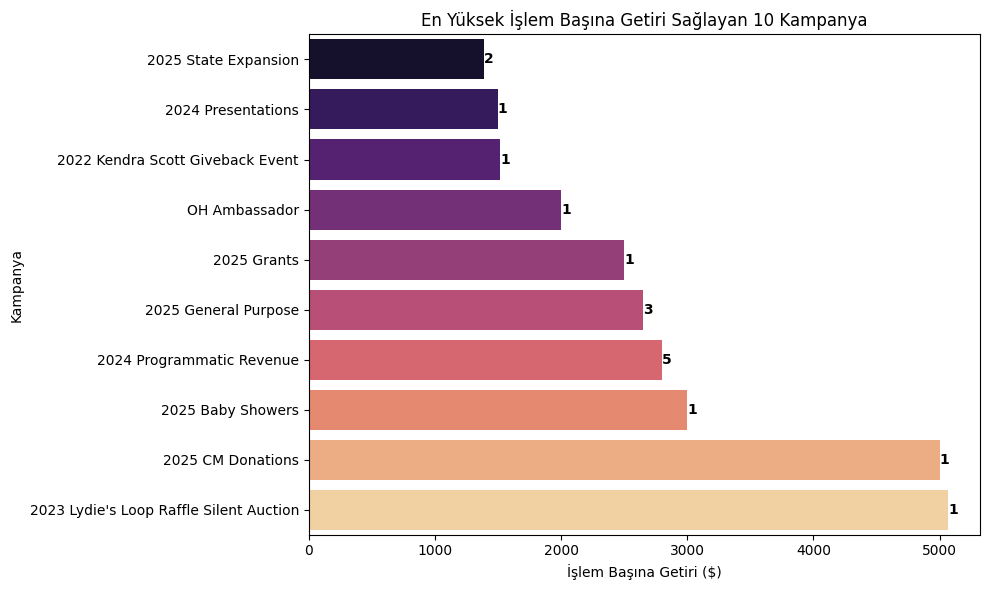


Y√ºksek Getiri / D√º≈ü√ºk Satƒ±≈ü Kampanyalarƒ±:
                                         transaction_count  total_revenue  \
campaign.name                                                               
2023 Lydie's Loop Raffle Silent Auction                  1        5067.00   
2025 CM Donations                                        1        5000.00   
2025 Baby Showers                                        1        3000.00   
2024 Programmatic Revenue                                5       70050.00   
2025 General Purpose                                     3       23850.00   
2025 Grants                                              1        2500.00   
OH Ambassador                                            1        2000.00   
2022 Kendra Scott Giveback Event                         1        1516.45   
2024 Presentations                                       1        1500.00   
2025 State Expansion                                     2        5550.00   

                         

In [62]:
# Kampanyalarƒ±n getiri-satƒ±≈ü analizi: Her kampanyanƒ±n i≈ülem ba≈üƒ±na getirisini ve kullanƒ±m sayƒ±sƒ±nƒ± hesaplƒ±yoruz
df['revenue_per_transaction'] = df['amount'] / df.groupby('campaign.name')['amount'].transform('count')

high_revenue_low_sales = df.groupby('campaign.name').agg({
    'amount': ['count', 'sum'],
    'revenue_per_transaction': 'mean'
}).round(2)

# Kolon isimlerini sadele≈ütiriyoruz
high_revenue_low_sales.columns = ['transaction_count', 'total_revenue', 'revenue_per_transaction']

# En y√ºksek getiriye g√∂re sƒ±ralƒ±yoruz
high_revenue_low_sales = high_revenue_low_sales.sort_values('revenue_per_transaction', ascending=False)

# ƒ∞lk 10 kampanyayƒ± se√ßip, getiri ba≈üƒ±na getiriye g√∂re artan sƒ±raya diziyoruz
top10 = high_revenue_low_sales.head(10).sort_values('revenue_per_transaction')

# Bar grafiƒüi olu≈üturuyoruz
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10,
    x='revenue_per_transaction',
    y=top10.index,
    palette='magma'
)

plt.title('En Y√ºksek ƒ∞≈ülem Ba≈üƒ±na Getiri Saƒülayan 10 Kampanya')
plt.xlabel('ƒ∞≈ülem Ba≈üƒ±na Getiri ($)')
plt.ylabel('Kampanya')

# Her barƒ±n √ºzerine kampanyanƒ±n kullanƒ±m sayƒ±sƒ±nƒ± ekleyelim
for i, patch in enumerate(ax.patches):
    width = patch.get_width()
    campaign = top10.index[i]
    trans_count = top10.loc[campaign, 'transaction_count']
    ax.text(width + 0.05,
            patch.get_y() + patch.get_height() / 2,
            f"{trans_count}",
            fontweight='bold', color='black', va='center')

plt.tight_layout()
plt.savefig("enyuksekgetiri_with_usage.png", dpi=300)
plt.show()

print("\nY√ºksek Getiri / D√º≈ü√ºk Satƒ±≈ü Kampanyalarƒ±:")
print(high_revenue_low_sales.head(10))

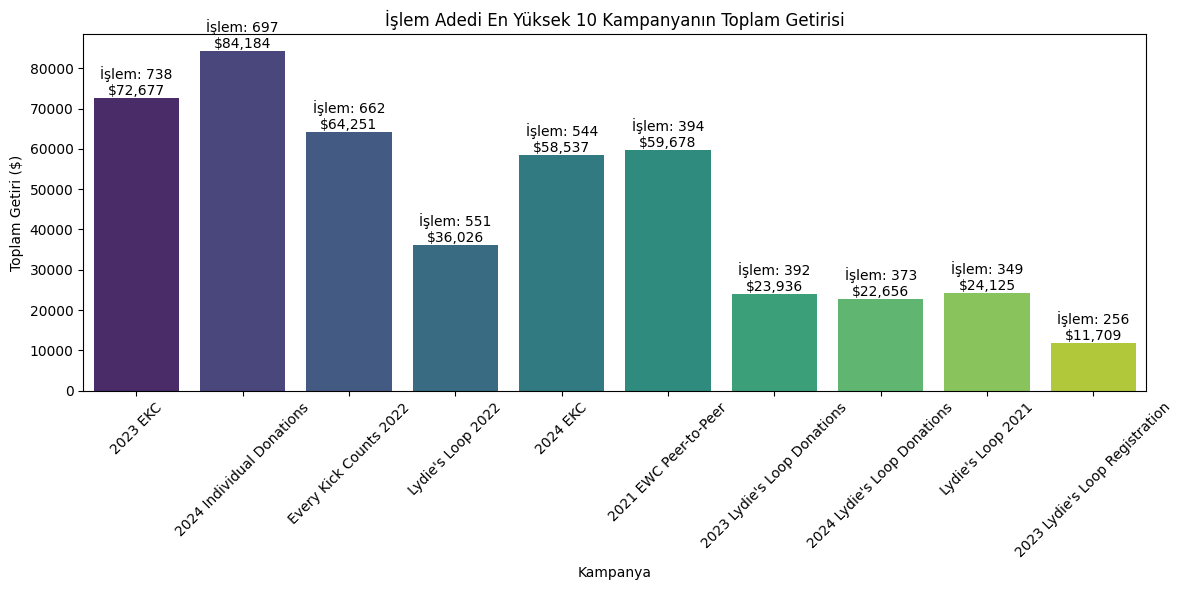


Top 10 Kampanya Detaylarƒ±:
                 campaign.name  transaction_count  total_revenue
                      2023 EKC                738       72676.70
     2024 Individual Donations                697       84183.71
        Every Kick Counts 2022                662       64250.91
             Lydie's Loop 2022                551       36026.50
                      2024 EKC                544       58536.89
         2021 EWC Peer-to-Peer                394       59678.25
   2023 Lydie's Loop Donations                392       23936.15
   2024 Lydie's Loop Donations                373       22656.06
             Lydie's Loop 2021                349       24124.60
2023 Lydie's Loop Registration                256       11708.70


In [66]:
# "No campaign" kayƒ±tlarƒ±nƒ± hari√ß tutarak kampanya verilerini filtreleyelim
df_campaign = df[df['campaign.name'] != 'No campaign']

# Her kampanya i√ßin i≈ülem adedi ve toplam getiriyi hesaplayalƒ±m
campaign_analysis = df_campaign.groupby('campaign.name').agg({
    'contactid': 'count',  # i≈ülem adedi
    'amount': 'sum'       # toplam getiri
}).reset_index()

# Kolon isimlerini d√ºzenleyelim
campaign_analysis.columns = ['campaign.name', 'transaction_count', 'total_revenue']

# ƒ∞≈ülem adedine g√∂re ilk 10 kampanyayƒ± se√ßelim
top10_campaigns = campaign_analysis.nlargest(10, 'transaction_count')

# Bar grafiƒüi olu≈üturalƒ±m
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top10_campaigns,
    x='campaign.name',
    y='total_revenue',
    palette='viridis'
)

plt.title('ƒ∞≈ülem Adedi En Y√ºksek 10 Kampanyanƒ±n Toplam Getirisi')
plt.xlabel('Kampanya')
plt.ylabel('Toplam Getiri ($)')
plt.xticks(rotation=45)

# Barlarƒ±n √ºzerine hem i≈ülem adedi hem de getiri bilgisini ekleyelim
for i, row in enumerate(top10_campaigns.itertuples()):
    ax.text(i, row.total_revenue, 
            f'ƒ∞≈ülem: {row.transaction_count}\n${row.total_revenue:,.0f}',
            ha='center', va='bottom')

plt.tight_layout()
plt.savefig("top10_campaign_revenue.png", dpi=300)
plt.show()

# Detaylƒ± bilgileri tablo olarak g√∂sterelim
print("\nTop 10 Kampanya Detaylarƒ±:")
print(top10_campaigns.to_string(index=False))

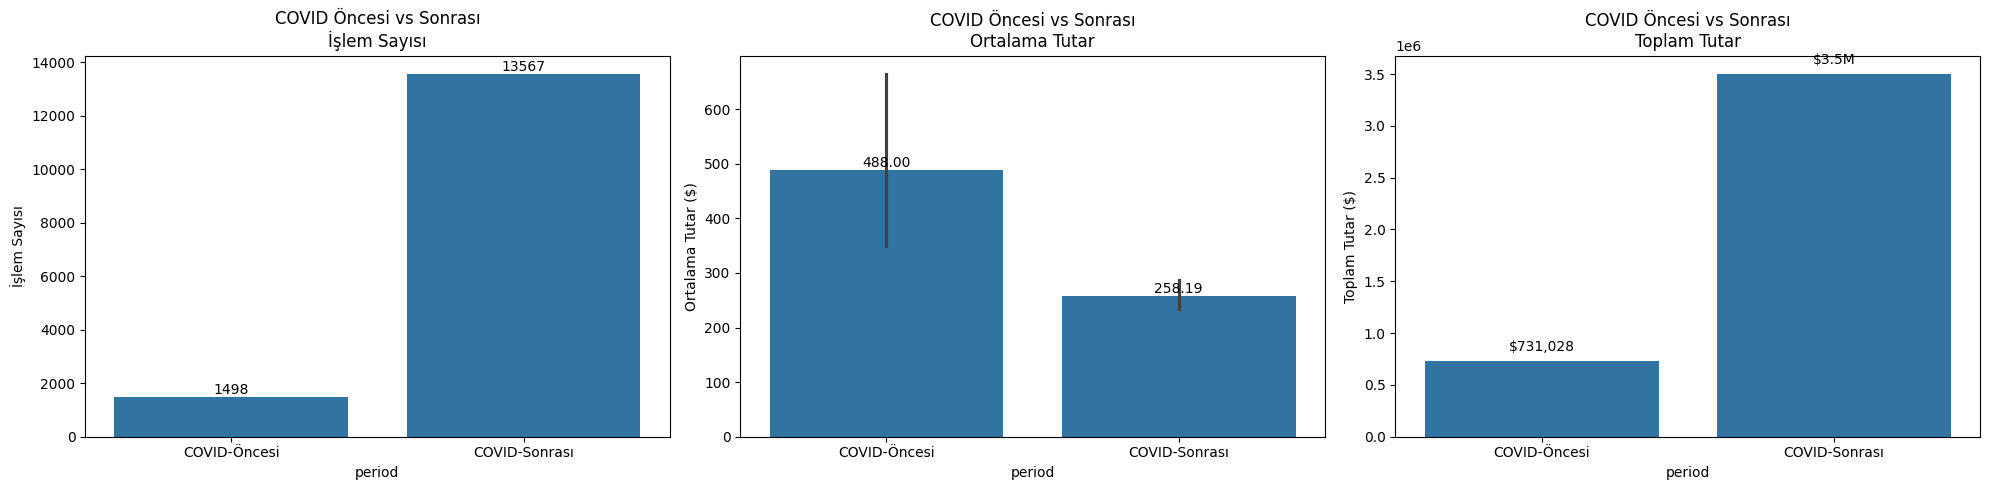


COVID Analizi Detaylarƒ±:
               transaction_count  total_amount  avg_amount
period                                                    
COVID-Sonrasƒ±              13567    3502909.23      258.19
COVID-√ñncesi                1498     731027.86      488.00


In [69]:
# 1. COVID-19 √ñncesi ve Sonrasƒ± Analiz (2020 Mart ayƒ± baz alƒ±narak)
df['closedate'] = pd.to_datetime(df['closedate'], errors='coerce')
df['period'] = df['closedate'].apply(lambda x: 'COVID-√ñncesi' if x < pd.Timestamp('2020-03-01') else 'COVID-Sonrasƒ±')

# COVID √∂ncesi ve sonrasƒ± performans kar≈üƒ±la≈ütƒ±rmasƒ±
covid_analysis = df.groupby('period').agg({
    'amount': ['count', 'sum', 'mean']
}).round(2)

covid_analysis.columns = ['transaction_count', 'total_amount', 'avg_amount']

# G√∂rselle≈ütirme - 3 grafik yan yana
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Sƒ±ralama i√ßin d√∂nem listesi olu≈ütur
period_order = ['COVID-√ñncesi', 'COVID-Sonrasƒ±']

# 1. ƒ∞≈ülem Sayƒ±sƒ± Kar≈üƒ±la≈ütƒ±rmasƒ±
sns.countplot(data=df, x='period', ax=ax1, order=period_order)
ax1.set_title('COVID √ñncesi vs Sonrasƒ±\nƒ∞≈ülem Sayƒ±sƒ±')
ax1.set_ylabel('ƒ∞≈ülem Sayƒ±sƒ±')
ax1.bar_label(ax1.containers[0])

# 2. Ortalama Tutar Kar≈üƒ±la≈ütƒ±rmasƒ±
sns.barplot(data=df, x='period', y='amount', estimator=np.mean, ax=ax2, order=period_order)
ax2.set_title('COVID √ñncesi vs Sonrasƒ±\nOrtalama Tutar')
ax2.set_ylabel('Ortalama Tutar ($)')
ax2.bar_label(ax2.containers[0], fmt='%.2f')

# 3. Toplam Tutar Kar≈üƒ±la≈ütƒ±rmasƒ±
period_totals = df.groupby('period')['amount'].sum()
sns.barplot(x=period_totals.index, y=period_totals.values, ax=ax3, order=period_order)
ax3.set_title('COVID √ñncesi vs Sonrasƒ±\nToplam Tutar')
ax3.set_ylabel('Toplam Tutar ($)')

# Milyon/Milyar formatƒ±nda etiketleri ekleyelim
def format_amount(x):
    if x >= 1e9:  # Milyar i√ßin
        return f'${x/1e9:.1f}B'
    elif x >= 1e6:  # Milyon i√ßin
        return f'${x/1e6:.1f}M'
    else:
        return f'${x:,.0f}'

ax3.bar_label(ax3.containers[0], 
              labels=[format_amount(x) for x in period_totals[period_order].values],
              padding=5)

plt.tight_layout()
plt.savefig("covid_analysis_complete.png", dpi=300)
plt.show()

# Detaylƒ± analiz sonu√ßlarƒ±nƒ± yazdƒ±ralƒ±m
print("\nCOVID Analizi Detaylarƒ±:")
print(covid_analysis)

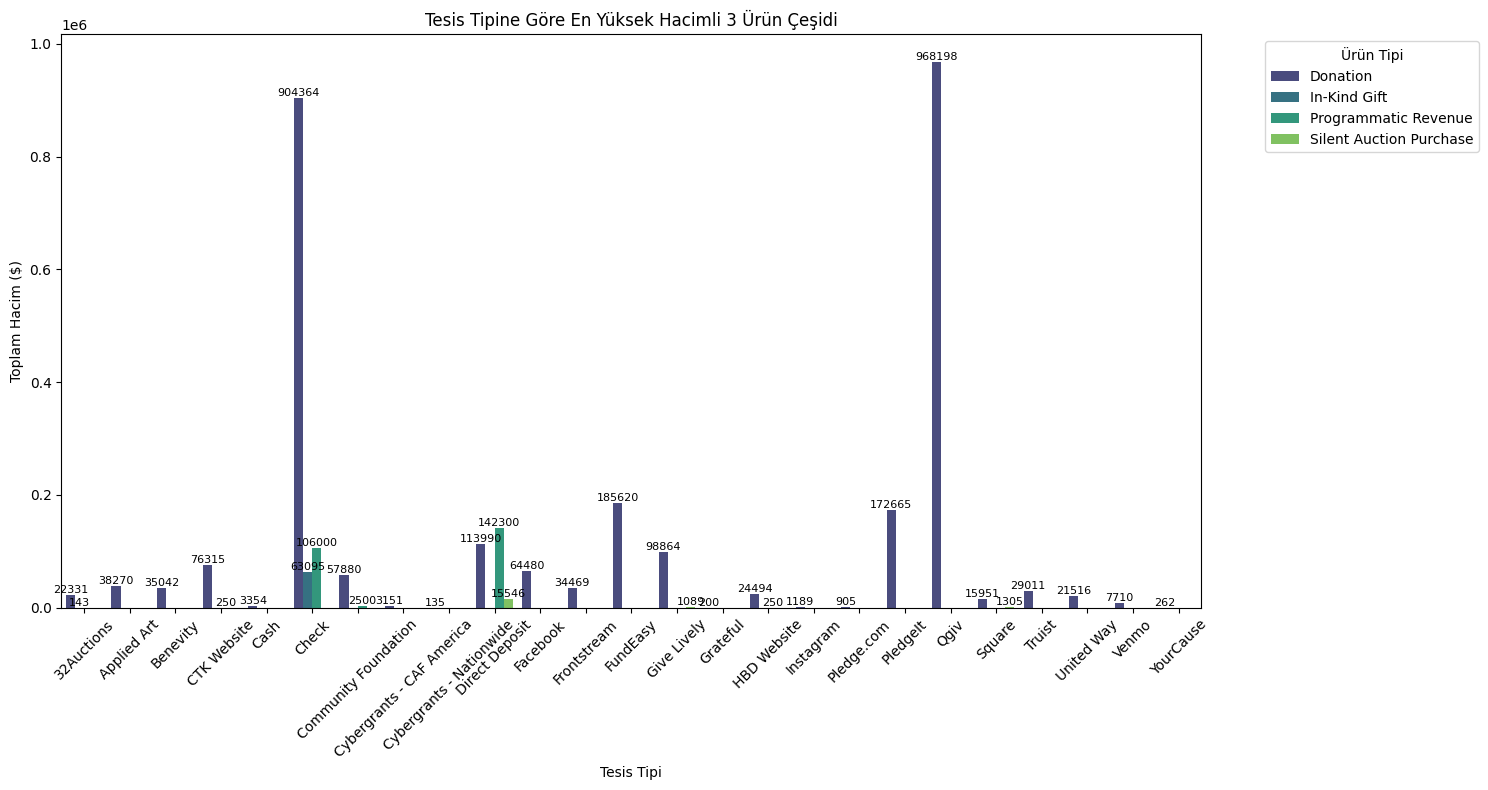


Tesis Tipine G√∂re En Y√ºksek Hacimli √úr√ºn √áe≈üitleri:
              platform__c         recordtype.name  transaction_count  total_amount
                     Qgiv                Donation               4975     968198.29
                    Check                Donation                899     904364.05
                 FundEasy                Donation                740     185619.65
                 PledgeIt                Donation               1978     172665.16
           Direct Deposit    Programmatic Revenue                 13     142300.00
           Direct Deposit                Donation                 54     113990.18
                    Check    Programmatic Revenue                 34     106000.00
              Give Lively                Donation                865      98863.92
              CTK Website                Donation                411      76315.10
                 Facebook                Donation                846      64480.14
                    Check   

In [72]:
# "No campaign" kayƒ±tlarƒ±nƒ± hari√ß tutarak filtreleme yapalƒ±m
df_filtered = df[df['campaign.name'] != 'No campaign']

# Tesis tipi ve √ºr√ºn tipi bazlƒ± toplam i≈ülem hacmini hesaplayalƒ±m
platform_product_volume = (
    df_filtered.groupby(['platform__c', 'recordtype.name']).agg({
        'amount': ['count', 'sum']  # ƒ∞≈ülem sayƒ±sƒ± ve toplam tutar
    }).round(2)
)

# Kolon isimlerini d√ºzenleyelim
platform_product_volume.columns = ['transaction_count', 'total_amount']
platform_product_volume = platform_product_volume.reset_index()

# Her tesis tipi i√ßin en y√ºksek hacimli ilk 3 √ºr√ºn tipini se√ßelim
top_products_by_platform = (
    platform_product_volume
    .sort_values(['platform__c', 'total_amount'], ascending=[True, False])
    .groupby('platform__c')
    .head(3)
)

# G√∂rselle≈ütirme
plt.figure(figsize=(15, 8))
ax = sns.barplot(
    data=top_products_by_platform,
    x='platform__c',
    y='total_amount',
    hue='recordtype.name',
    palette='viridis'
)

plt.title('Tesis Tipine G√∂re En Y√ºksek Hacimli 3 √úr√ºn √áe≈üidi')
plt.xlabel('Tesis Tipi')
plt.ylabel('Toplam Hacim ($)')
plt.xticks(rotation=45)

# Bar etiketlerini ekleyelim
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=8)

plt.legend(title='√úr√ºn Tipi', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("platform_top_products.png", dpi=300, bbox_inches='tight')
plt.show()

# Detaylƒ± analiz sonu√ßlarƒ±nƒ± tablo olarak g√∂sterelim
print("\nTesis Tipine G√∂re En Y√ºksek Hacimli √úr√ºn √áe≈üitleri:")
print(top_products_by_platform.sort_values('total_amount', ascending=False).to_string(index=False))